In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [2]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


# Get Data Spectra

In [8]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['centre_beta'] < hbeta + 5)*
    (wdtable['centre_beta'] > hbeta - 5)*
    (wdtable['centre_alpha'] > halpha - 5)*
    (wdtable['centre_alpha'] < halpha + 5) * 
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 13000) * 
    (wdtable['TeffH'] < 80000) * 
    (wdtable['subclass'] == 'WD')[:,0].data*
    (wdtable['S2N'] > 3)
)
notgoodtable = wdtable[~good]
wdtable = wdtable[good]
len(wdtable)

552

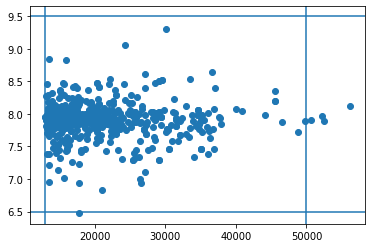

In [9]:
plt.scatter(wdtable['TeffH'],wdtable['loggH'])
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(13000)
plt.axvline(50000)

In [10]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

# def rvcorr(spectrum):
#     lamgrid = np.arange(4000,8000)
#     coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
#     coremask = coremask.astype(int)
#     trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
#     if trans > 5:
#         trans = 5;
#     elif trans < 5:
#         trans = -5;
#     else:
#         ;
#     shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
#     return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

100%|██████████| 552/552 [01:45<00:00,  5.99it/s]


In [11]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [12]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 552/552 [00:01<00:00, 383.18it/s]


552

# Train Generator

In [13]:
sc = StandardScaler()

X = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())
t = normspec
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1,random_state=13)

In [15]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(32,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(32,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3000)              99000     
Total params: 100,152
Trainable params: 100,152
Non-trainable params: 0
_________________________________________________________________
None

In [404]:
epoch = 1000
batch = len(X_train)

history = model.fit(X,t,epochs=epoch,verbose=0,batch_size=batch,validation_data = (X_test,y_test))

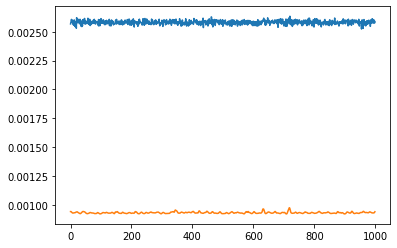

In [405]:
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))

### Evaluate TeFF Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

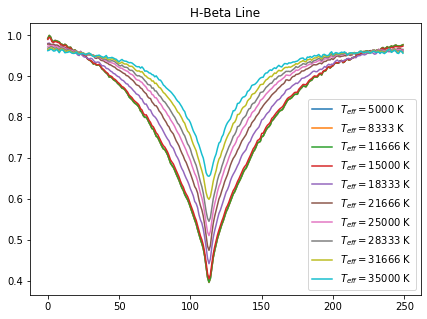

In [406]:
plt.figure(figsize=(7,5))
ts = np.linspace(5000,35000,10)
ls = np.linspace(8,8,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate logg Sensitivity

Text(0.5, 0.98, 'H-Delta')

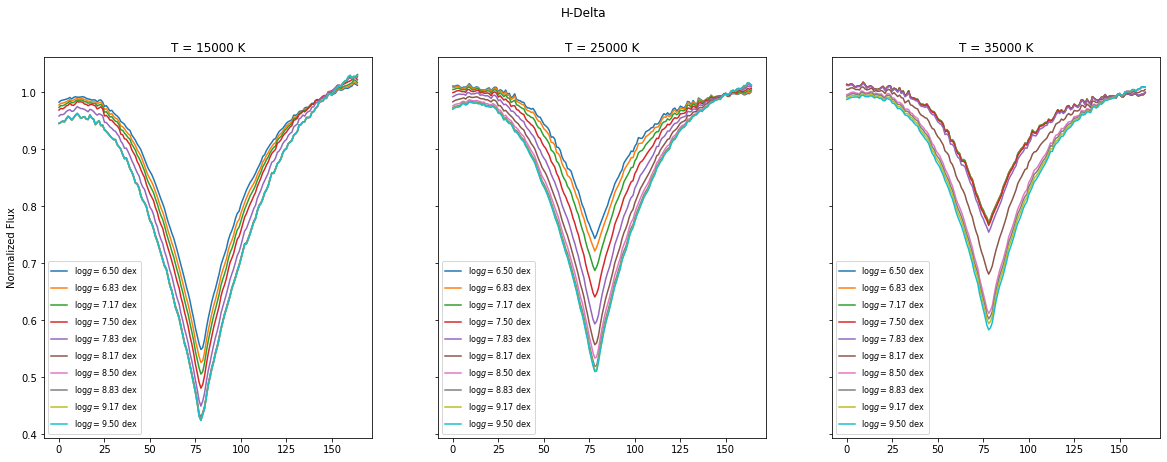

In [410]:
f,axs = plt.subplots(1,3,sharey = True,figsize=(20,7))

ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    axs[0].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

axs[0].legend(fontsize=8)
axs[0].set_title('T = 15000 K')
axs[0].set_ylabel('Normalized Flux')

ts = np.linspace(25000,25000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    axs[1].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

axs[1].legend(fontsize=8)
axs[1].set_title('T = 25000 K')

ts = np.linspace(35000,35000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    axs[2].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

axs[2].legend(fontsize=8)
axs[2].set_title('T = 35000 K')

# plt.subplot(132)
# ts = np.linspace(25000,25000,10)
# ls = np.linspace(6.5,9.5,10)
# samples = sc.transform(np.stack((ts,ls)).transpose())
# gens = model.predict(samples)
# for i in range(len(gens)):
#     plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

# plt.legend(fontsize=8)
# plt.title('T = 25000 K')

# plt.subplot(133)
# ts = np.linspace(35000,35000,10)
# ls = np.linspace(6.5,9.5,10)
# samples = sc.transform(np.stack((ts,ls)).transpose())
# gens = model.predict(samples)
# for i in range(len(gens)):
#     plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

# plt.legend(fontsize=8)
# plt.title('T = 35000 K')

plt.suptitle('H-Delta')

### Evaluate Residuals of Random Control Spectra

Text(0.5, 1.0, 'Sample of Model Residuals')

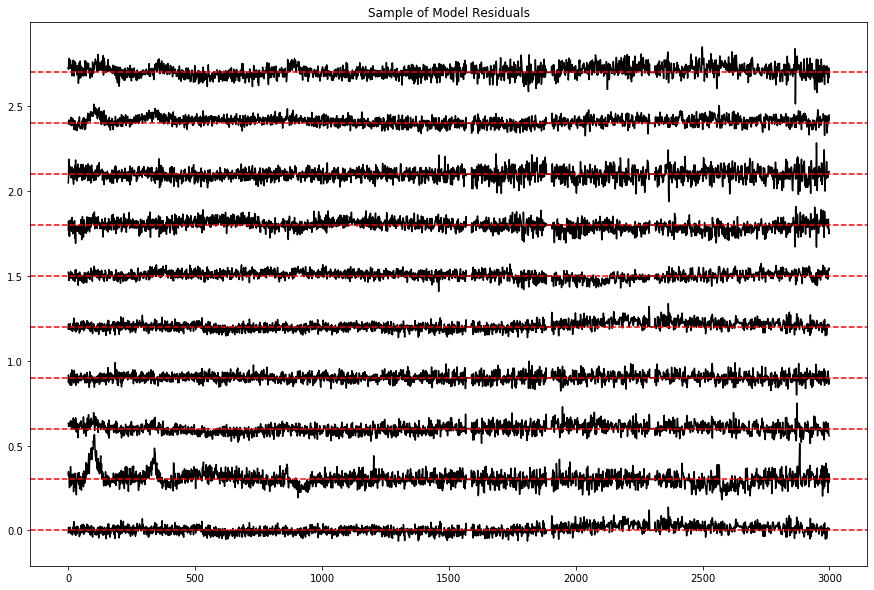

In [245]:
resids = y_test - model.predict(X_test)
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.3*ct,'k')
    plt.axhline(0.3*ct,color='r',linestyle='--')
    ct += 1
plt.title('Sample of Model Residuals')

In [246]:
modelscaling = 1
from astropy.convolution import Gaussian1DKernel
from scipy.signal import convolve as scipy_convolve
def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    synth = (interpolation.shift(model.predict(label)[0],trans,cval=np.nan)*modelscaling)
    newsynth = scipy_convolve(synth,Gaussian1DKernel(5),'same')
    return synth[lines].astype('float32')

def chisquare(residual):
    return sum(residual**2)

In [267]:
lamgrid = np.arange(4000,7000)
fitter = lmfit.Model(spectrum_sampler)
params = fitter.make_params(teff = 20000.,logg=8.,trans=0.)
params['teff'].set(min=13000,max=80000)
params['logg'].set(min=6.5,max=9.5)
params['trans'].set(min=-10,max=10,vary=True)

bayesparams = fitter.make_params(teff = 20000.,logg=8.,trans=0.)
bayesparams['teff'].set(min=13000,max=80000)
bayesparams['logg'].set(min=6.5,max=9.5)

In [268]:
lam = lamgrid
lines = lines = ((lam > hbeta-200) & (lam < hbeta + 200)) | ((lam > halpha-200) & (lam < halpha + 200))\
        | ((lam > hgamma-320) & (lam < hgamma + 100))




























  0%|          | 0/56 [00:00<?, ?it/s]

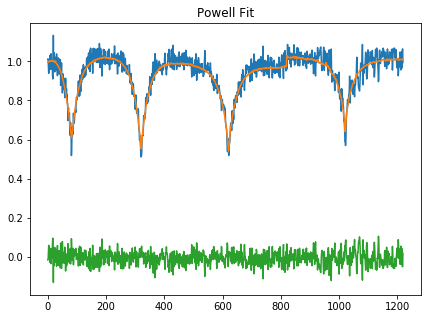

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 92
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.49284531
    reduced chi-square = 0.00122666
    Akaike info crit   = -8175.22513
    Bayesian info crit = -8159.90531
[[Variables]]
    teff:   28439.6403 +/- 2264.75449 (7.96%) (init = 20000)
    logg:   7.99341565 +/- 0.16869325 (2.11%) (init = 8)
    trans:  0.38480667 +/- 0.17654076 (45.88%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.994

 Starting Bayesian Sampling................
...Done.


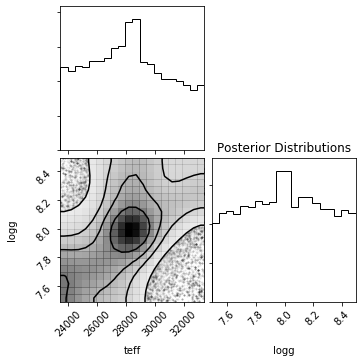

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.49384041
    reduced chi-square = 0.00122647
    Akaike info crit   = -8176.41217
    Bayesian info crit = -8166.19896
[[Variables]]
    teff:   28206.9133 +/- 3127.50799 (11.09%) (init = 28439.64)
    logg:   7.99419697 +/- 0.32461118 (4.06%) (init = 7.993416)
    trans:  0.3848067 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.203


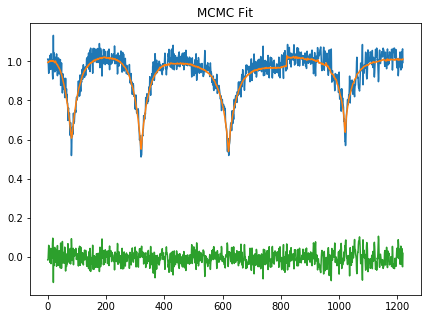




























  2%|▏         | 1/56 [00:36<33:01, 36.03s/it]

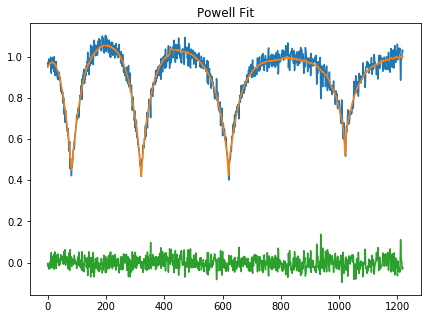

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 344
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.01789649
    reduced chi-square = 8.3640e-04
    Akaike info crit   = -8642.41885
    Bayesian info crit = -8627.09903
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   15011.5859 +/- 9.49249476 (0.06%) (init = 20000)
    logg:   7.84599271 +/-        nan (nan%) (init = 8)
    trans:  0.39200379 +/- 0.12283637 (31.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, trans) =  0.567

 Starting Bayesian Sampling................
...Done.


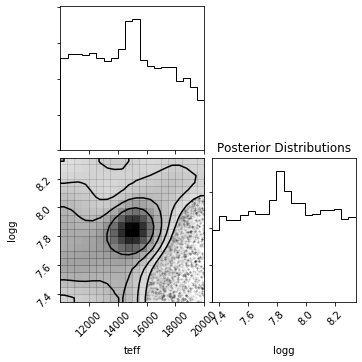

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.02465137
    reduced chi-square = 8.4126e-04
    Akaike info crit   = -8636.34952
    Bayesian info crit = -8626.13631
[[Variables]]
    teff:   14728.5724 +/- 3161.09566 (21.46%) (init = 15011.59)
    logg:   7.84736894 +/- 0.32379997 (4.13%) (init = 7.845993)
    trans:  0.3920038 (fixed)


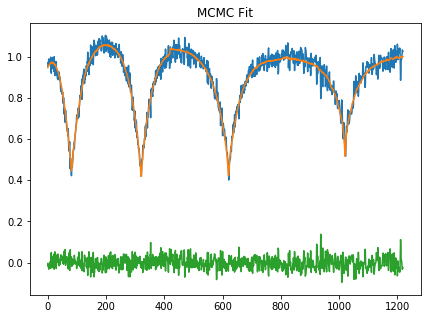




























  4%|▎         | 2/56 [01:11<32:17, 35.87s/it]

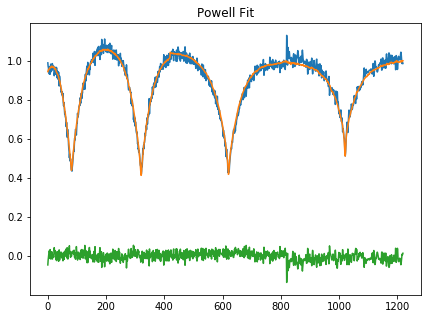

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 437
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.58837054
    reduced chi-square = 4.8346e-04
    Akaike info crit   = -9311.14549
    Bayesian info crit = -9295.82568
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   13089.2010 +/- 4.99787972 (0.04%) (init = 20000)
    logg:   7.79137106 +/-        nan (nan%) (init = 8)
    trans:  0.39523697 +/- 0.10220862 (25.86%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, trans) =  0.788

 Starting Bayesian Sampling................
...Done.


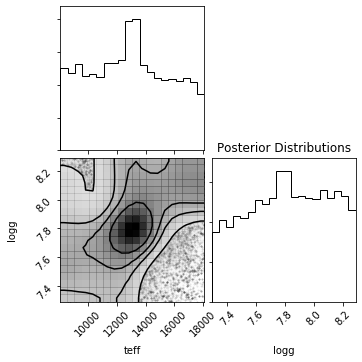

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.60767770
    reduced chi-square = 4.9891e-04
    Akaike info crit   = -9273.75446
    Bayesian info crit = -9263.54124
[[Variables]]
    teff:   12985.8629 +/- 3226.58149 (24.85%) (init = 13089.2)
    logg:   7.81446389 +/- 0.32189178 (4.12%) (init = 7.791371)
    trans:  0.395237 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.192


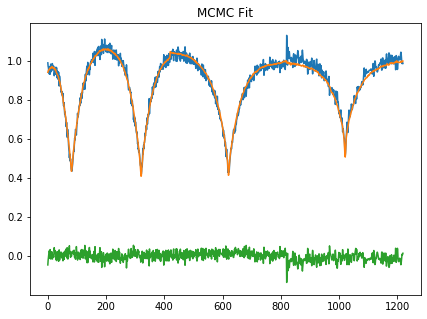




























  5%|▌         | 3/56 [01:47<31:36, 35.78s/it]

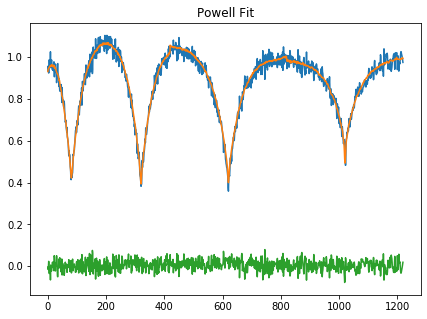

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 169
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.72979258
    reduced chi-square = 5.9967e-04
    Akaike info crit   = -9048.35329
    Bayesian info crit = -9033.03347
[[Variables]]
    teff:   13000.0115 +/- 3.21169468 (0.02%) (init = 20000)
    logg:   8.40819089 +/- 0.57340125 (6.82%) (init = 8)
    trans: -0.05275206 +/- 0.10231696 (193.96%) (init = 0)

 Starting Bayesian Sampling................
...Done.


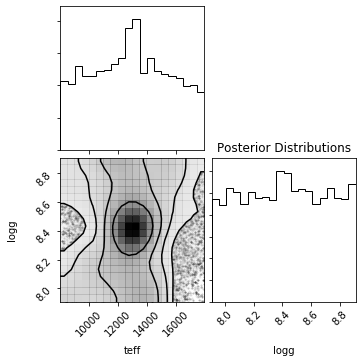

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.72989783
    reduced chi-square = 5.9926e-04
    Akaike info crit   = -9050.17736
    Bayesian info crit = -9039.96415
[[Variables]]
    teff:   12972.4068 +/- 3137.80397 (24.19%) (init = 13000.01)
    logg:   8.41047062 +/- 0.33811266 (4.02%) (init = 8.408191)
    trans: -0.05275206 (fixed)


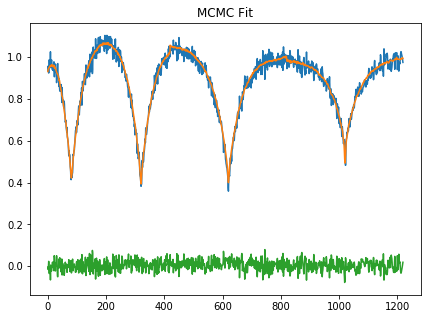




























  7%|▋         | 4/56 [02:22<30:47, 35.53s/it]

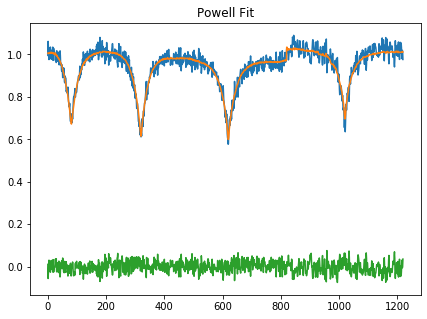

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 115
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.81378370
    reduced chi-square = 6.6868e-04
    Akaike info crit   = -8915.45351
    Bayesian info crit = -8900.13369
[[Variables]]
    teff:   32377.4340 +/- 2709.96770 (8.37%) (init = 20000)
    logg:   8.00000891 +/- 0.16140134 (2.02%) (init = 8)
    trans: -0.21542659 +/- 0.15908708 (73.85%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.999

 Starting Bayesian Sampling................
...Done.


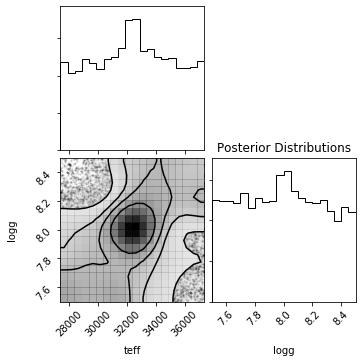

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.81394901
    reduced chi-square = 6.6827e-04
    Akaike info crit   = -8917.20571
    Bayesian info crit = -8906.99250
[[Variables]]
    teff:   32385.8530 +/- 3233.05116 (9.98%) (init = 32377.43)
    logg:   7.99783166 +/- 0.32914855 (4.12%) (init = 8.000009)
    trans: -0.2154266 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.120


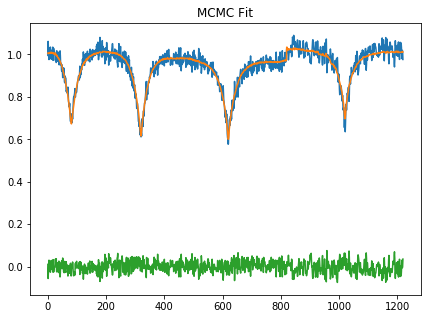




























  9%|▉         | 5/56 [02:56<29:59, 35.28s/it]

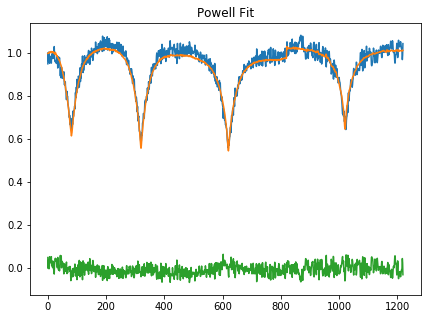

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 103
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.75703777
    reduced chi-square = 6.2205e-04
    Akaike info crit   = -9003.63690
    Bayesian info crit = -8988.31708
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   28928.5085 +/-        nan (nan%) (init = 20000)
    logg:   8.00225747 +/-        nan (nan%) (init = 8)
    trans: -0.01250722 +/- 0.17333848 (1385.91%) (init = 0)

 Starting Bayesian Sampling................
...Done.


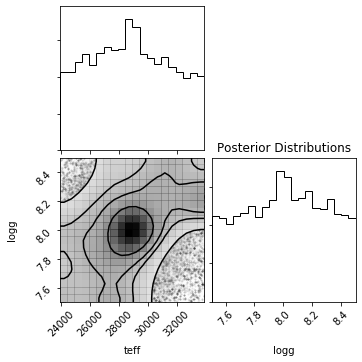

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.75768416
    reduced chi-square = 6.2207e-04
    Akaike info crit   = -9004.59565
    Bayesian info crit = -8994.38243
[[Variables]]
    teff:   28847.0620 +/- 3164.47119 (10.97%) (init = 28928.51)
    logg:   8.01027224 +/- 0.32241051 (4.02%) (init = 8.002257)
    trans: -0.01250722 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.149


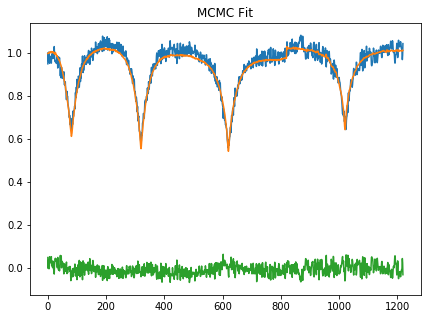




























 11%|█         | 6/56 [03:31<29:17, 35.15s/it]

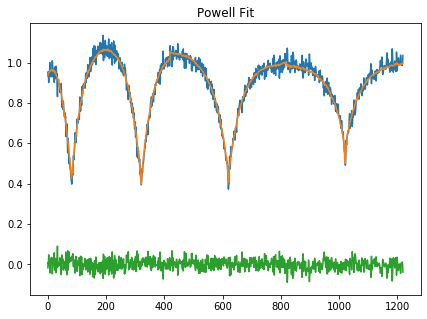

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 341
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.75716870
    reduced chi-square = 6.2216e-04
    Akaike info crit   = -9003.42590
    Bayesian info crit = -8988.10609
[[Variables]]
    teff:   13000.0032 +/- 2.24121818 (0.02%) (init = 20000)
    logg:   7.89331705 +/- 0.01296285 (0.16%) (init = 8)
    trans:  0.22918036 +/- 0.11081642 (48.35%) (init = 0)

 Starting Bayesian Sampling................
...Done.


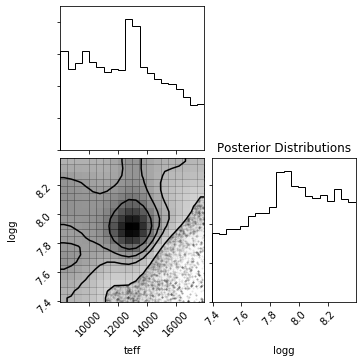

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.76301394
    reduced chi-square = 6.2645e-04
    Akaike info crit   = -8996.04384
    Bayesian info crit = -8985.83063
[[Variables]]
    teff:   12636.4320 +/- 3099.84329 (24.53%) (init = 13000)
    logg:   7.93886633 +/- 0.31840041 (4.01%) (init = 7.893317)
    trans:  0.2291804 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.124


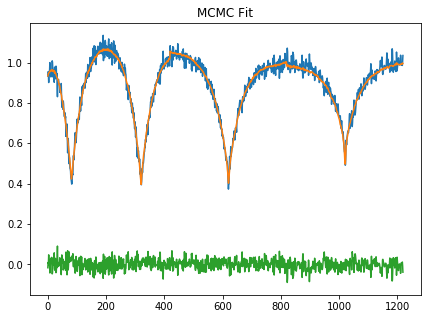




























 12%|█▎        | 7/56 [04:06<28:44, 35.19s/it]

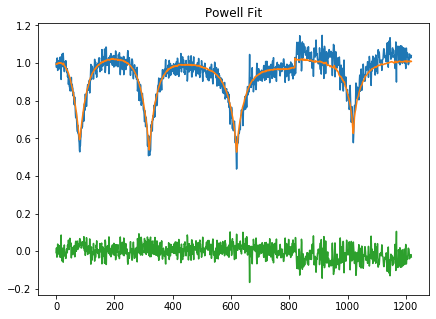

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 81
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.97412065
    reduced chi-square = 0.00162212
    Akaike info crit   = -7834.30936
    Bayesian info crit = -7818.98954
[[Variables]]
    teff:   26773.9928 +/- 2031.94094 (7.59%) (init = 20000)
    logg:   7.97738330 +/- 0.18495831 (2.32%) (init = 8)
    trans: -0.62329167 +/- 0.18557560 (29.77%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg)  =  0.990
    C(teff, trans) = -0.167
    C(logg, trans) = -0.166

 Starting Bayesian Sampling................
...Done.


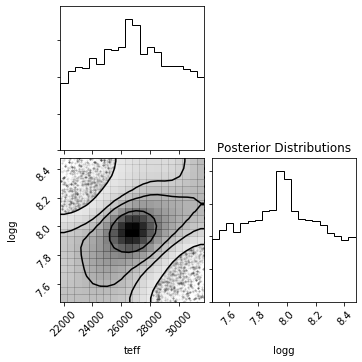

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.97428553
    reduced chi-square = 0.00162092
    Akaike info crit   = -7836.20746
    Bayesian info crit = -7825.99425
[[Variables]]
    teff:   26771.4846 +/- 3136.16456 (11.71%) (init = 26773.99)
    logg:   7.97426280 +/- 0.30746600 (3.86%) (init = 7.977383)
    trans: -0.6232917 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.199


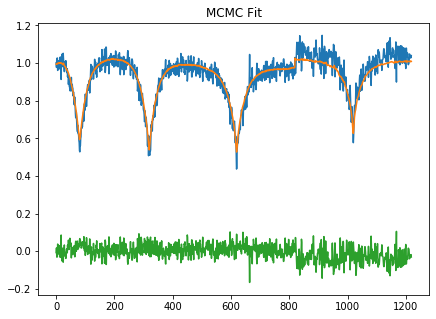




























 14%|█▍        | 8/56 [04:42<28:16, 35.34s/it]

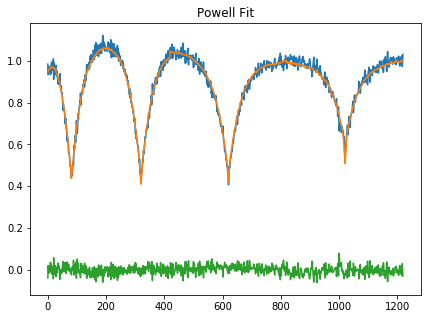

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 461
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.46868517
    reduced chi-square = 3.8512e-04
    Akaike info crit   = -9588.60478
    Bayesian info crit = -9573.28497
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   13006.9093 +/- 6.76332840 (0.05%) (init = 20000)
    logg:   7.80372401 +/-        nan (nan%) (init = 8)
    trans: -0.01929998 +/- 0.10291870 (533.26%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, trans) =  0.969

 Starting Bayesian Sampling................
...Done.


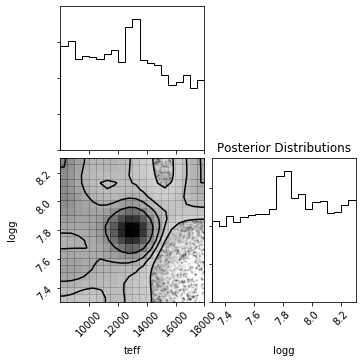

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.48765962
    reduced chi-square = 4.0038e-04
    Akaike info crit   = -9542.18737
    Bayesian info crit = -9531.97416
[[Variables]]
    teff:   12683.2192 +/- 3269.37047 (25.78%) (init = 13006.91)
    logg:   7.82187890 +/- 0.32698551 (4.18%) (init = 7.803724)
    trans: -0.01929998 (fixed)


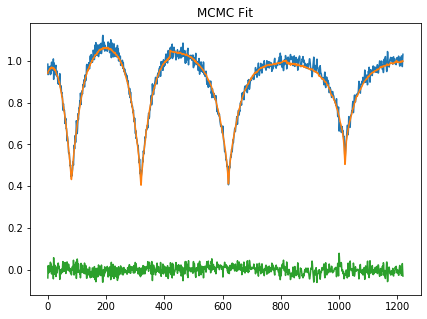




























 16%|█▌        | 9/56 [05:17<27:35, 35.23s/it]

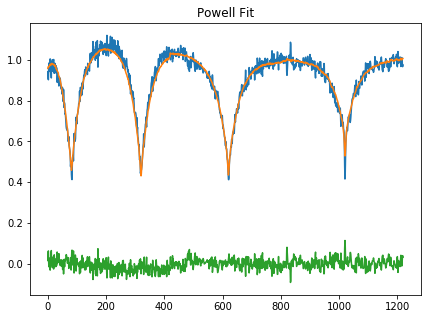

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 269
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.83438039
    reduced chi-square = 6.8560e-04
    Akaike info crit   = -8884.95986
    Bayesian info crit = -8869.64004
[[Variables]]
    teff:   13008.3714 +/- 72.4438582 (0.56%) (init = 20000)
    logg:   7.62289932 +/- 0.02393293 (0.31%) (init = 8)
    trans:  0.17453020 +/- 0.11394983 (65.29%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.216

 Starting Bayesian Sampling................
...Done.


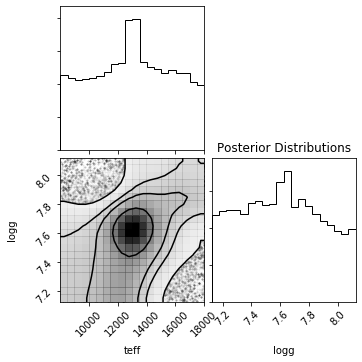

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.83493693
    reduced chi-square = 6.8550e-04
    Akaike info crit   = -8886.14638
    Bayesian info crit = -8875.93317
[[Variables]]
    teff:   13009.6605 +/- 3170.86633 (24.37%) (init = 13008.37)
    logg:   7.61055261 +/- 0.31688373 (4.16%) (init = 7.622899)
    trans:  0.1745302 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.140


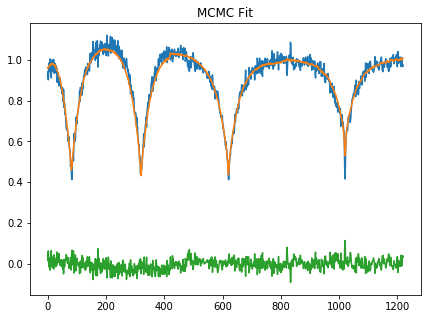




























 18%|█▊        | 10/56 [05:52<27:02, 35.27s/it]

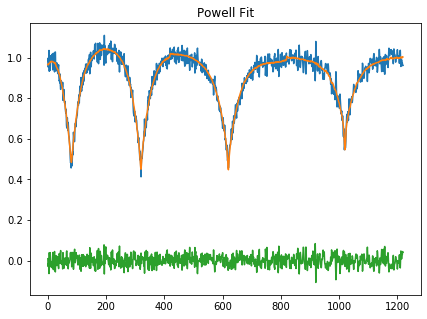

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 286
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.82591791
    reduced chi-square = 6.7865e-04
    Akaike info crit   = -8897.39655
    Bayesian info crit = -8882.07673
[[Variables]]
    teff:   17008.6800 +/- 249.402841 (1.47%) (init = 20000)
    logg:   7.86113052 +/- 0.01885316 (0.24%) (init = 8)
    trans: -0.23195301 +/- 0.12314386 (53.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.952

 Starting Bayesian Sampling................
...Done.


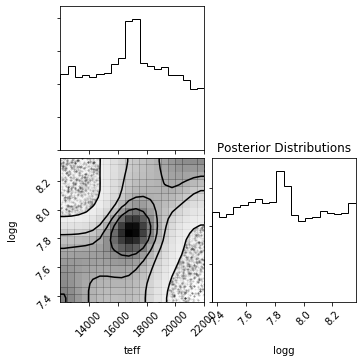

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.82738422
    reduced chi-square = 6.7930e-04
    Akaike info crit   = -8897.23253
    Bayesian info crit = -8887.01931
[[Variables]]
    teff:   16999.1543 +/- 3182.75817 (18.72%) (init = 17008.68)
    logg:   7.85206047 +/- 0.33208270 (4.23%) (init = 7.861131)
    trans: -0.231953 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.205


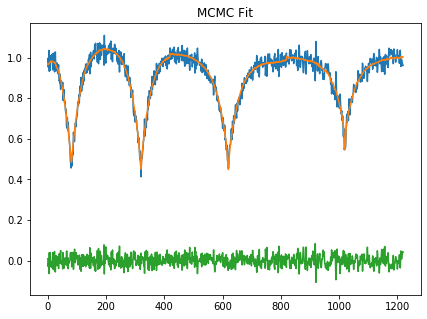




























 20%|█▉        | 11/56 [06:27<26:23, 35.18s/it]

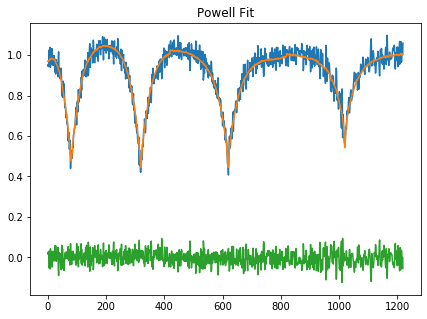

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 245
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.33170286
    reduced chi-square = 0.00109425
    Akaike info crit   = -8314.58016
    Bayesian info crit = -8299.26034
[[Variables]]
    teff:   15736.4759 +/- 444.112132 (2.82%) (init = 20000)
    logg:   7.73973346 +/- 0.05094707 (0.66%) (init = 8)
    trans: -0.74378460 +/- 0.15310542 (20.58%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg)  =  0.936
    C(teff, trans) = -0.103

 Starting Bayesian Sampling................
...Done.


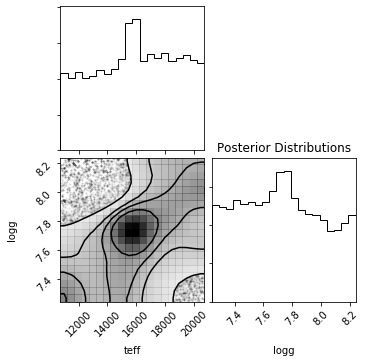

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.33197725
    reduced chi-square = 0.00109358
    Akaike info crit   = -8316.32880
    Bayesian info crit = -8306.11559
[[Variables]]
    teff:   15896.3201 +/- 3281.50408 (20.64%) (init = 15736.48)
    logg:   7.71911434 +/- 0.32187921 (4.17%) (init = 7.739733)
    trans: -0.7437846 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.182


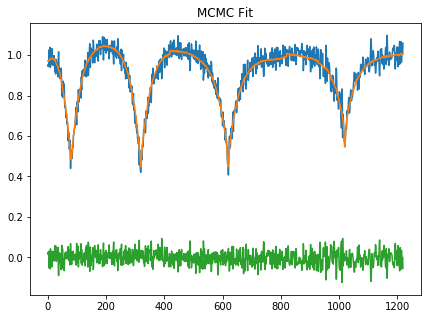




























 21%|██▏       | 12/56 [07:03<25:56, 35.36s/it]

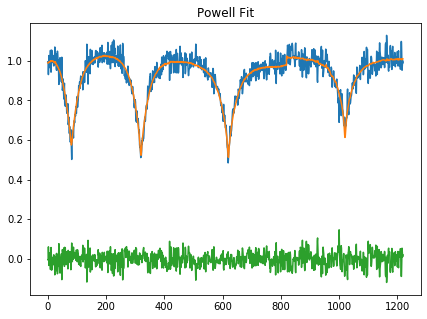

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 91
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.45017988
    reduced chi-square = 0.00119160
    Akaike info crit   = -8210.60061
    Bayesian info crit = -8195.28079
[[Variables]]
    teff:   25354.9762 +/- 2184.44435 (8.62%) (init = 20000)
    logg:   7.99060239 +/- 0.24880860 (3.11%) (init = 8)
    trans: -0.09419623 +/- 0.16219737 (172.19%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.994

 Starting Bayesian Sampling................
...Done.


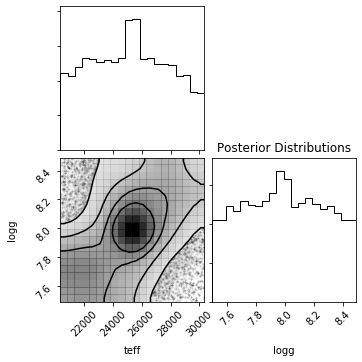

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.45028850
    reduced chi-square = 0.00119071
    Akaike info crit   = -8212.50924
    Bayesian info crit = -8202.29603
[[Variables]]
    teff:   25280.4663 +/- 3103.40637 (12.28%) (init = 25354.98)
    logg:   7.98921414 +/- 0.32223239 (4.03%) (init = 7.990602)
    trans: -0.09419623 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.192


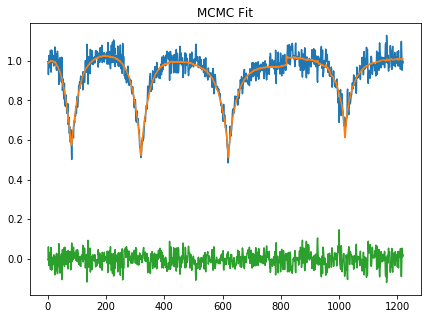




























 23%|██▎       | 13/56 [07:39<25:25, 35.49s/it]

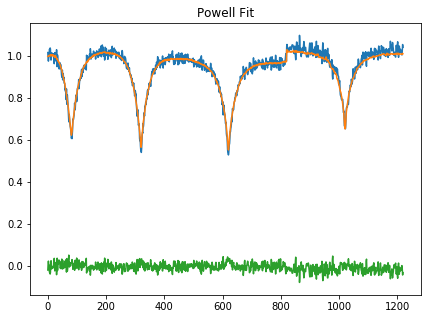

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 111
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.45162240
    reduced chi-square = 3.7109e-04
    Akaike info crit   = -9633.84828
    Bayesian info crit = -9618.52846
[[Variables]]
    teff:   29681.9723 +/- 1178.27501 (3.97%) (init = 20000)
    logg:   8.00153399 +/- 0.07834384 (0.98%) (init = 8)
    trans:  0.04486274 +/- 0.10646875 (237.32%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.995

 Starting Bayesian Sampling................
...Done.


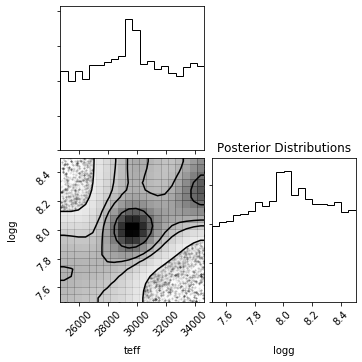

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.45275905
    reduced chi-square = 3.7172e-04
    Akaike info crit   = -9632.78161
    Bayesian info crit = -9622.56840
[[Variables]]
    teff:   29680.0573 +/- 3256.29116 (10.97%) (init = 29681.97)
    logg:   8.01554344 +/- 0.32203996 (4.02%) (init = 8.001534)
    trans:  0.04486274 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.190


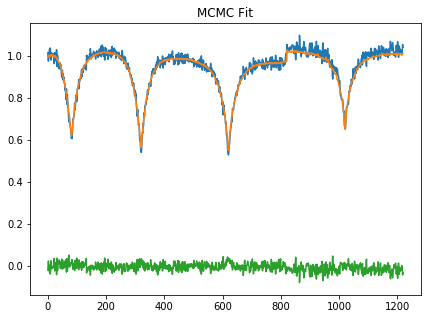




























 25%|██▌       | 14/56 [08:14<24:45, 35.38s/it]

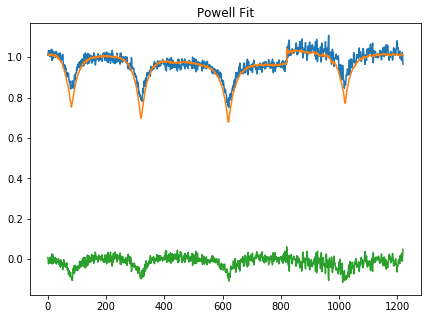

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 154
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.19582341
    reduced chi-square = 9.8260e-04
    Akaike info crit   = -8445.88079
    Bayesian info crit = -8430.56098
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   76395.7115 (init = 20000)
    logg:   7.18458528 (init = 8)
    trans:  0.14747629 (init = 0)

 Starting Bayesian Sampling................
...Done.


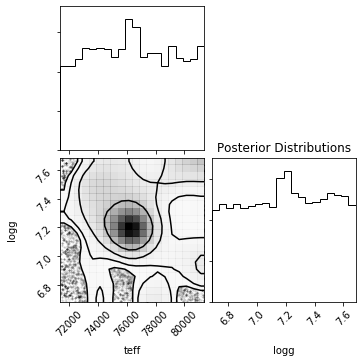

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.19589508
    reduced chi-square = 9.8185e-04
    Akaike info crit   = -8447.80768
    Bayesian info crit = -8437.59447
[[Variables]]
    teff:   76390.8225 +/- 3283.19348 (4.30%) (init = 76395.71)
    logg:   7.19438989 +/- 0.33506548 (4.66%) (init = 7.184585)
    trans:  0.1474763 (fixed)


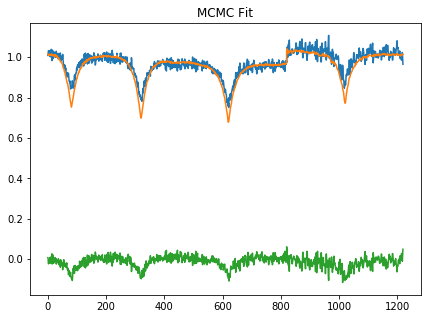




























 27%|██▋       | 15/56 [08:49<24:05, 35.26s/it]

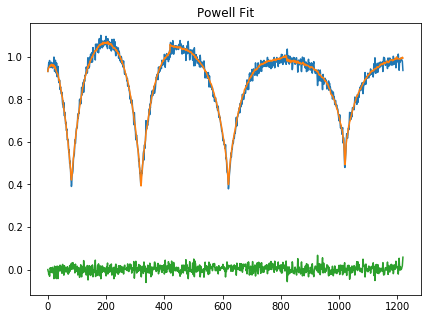

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 154
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.35896320
    reduced chi-square = 2.9496e-04
    Akaike info crit   = -9913.99267
    Bayesian info crit = -9898.67285
[[Variables]]
    teff:   13000.0178 +/- 3.69828551 (0.03%) (init = 20000)
    logg:   8.52040835 +/- 0.60210042 (7.07%) (init = 8)
    trans: -0.00677910 +/- 0.07947298 (1172.32%) (init = 0)

 Starting Bayesian Sampling................
...Done.


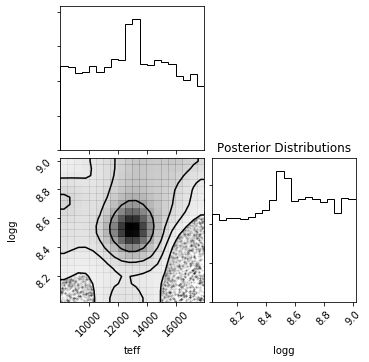

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.35910038
    reduced chi-square = 2.9483e-04
    Akaike info crit   = -9915.52655
    Bayesian info crit = -9905.31333
[[Variables]]
    teff:   12994.8298 +/- 3186.13107 (24.52%) (init = 13000.02)
    logg:   8.54008136 +/- 0.32936623 (3.86%) (init = 8.520408)
    trans: -0.006779098 (fixed)


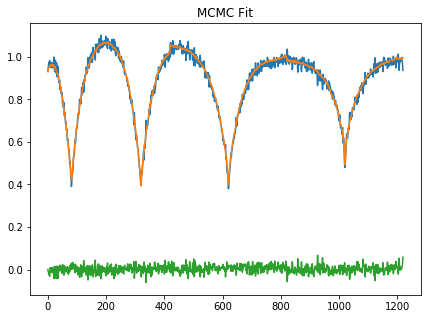




























 29%|██▊       | 16/56 [09:24<23:22, 35.06s/it]

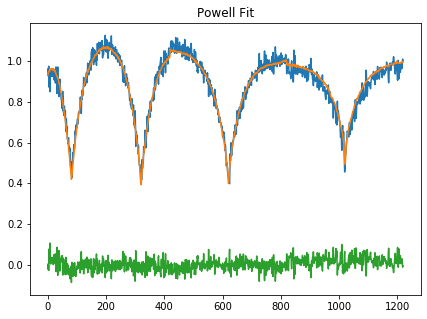

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 100
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.05985795
    reduced chi-square = 8.7088e-04
    Akaike info crit   = -8593.13492
    Bayesian info crit = -8577.81510
[[Variables]]
    teff:   13000.0007 +/- 0.63542324 (0.00%) (init = 20000)
    logg:   9.49832957 +/- 0.29825164 (3.14%) (init = 8)
    trans:  0.10618115 +/- 0.13272723 (125.00%) (init = 0)

 Starting Bayesian Sampling................
...Done.


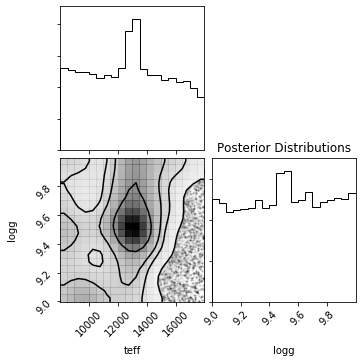

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.05969805
    reduced chi-square = 8.7003e-04
    Akaike info crit   = -8595.31900
    Bayesian info crit = -8585.10579
[[Variables]]
    teff:   12947.6484 +/- 3234.70672 (24.98%) (init = 13000)
    logg:   9.50487309 +/- 0.33870304 (3.56%) (init = 9.49833)
    trans:  0.1061812 (fixed)


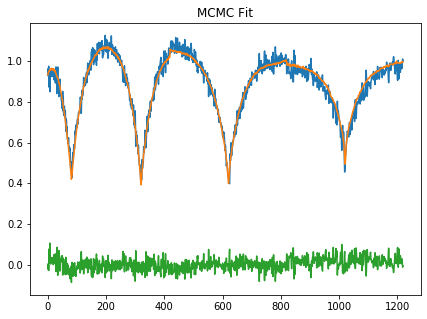




























 30%|███       | 17/56 [09:58<22:40, 34.89s/it]

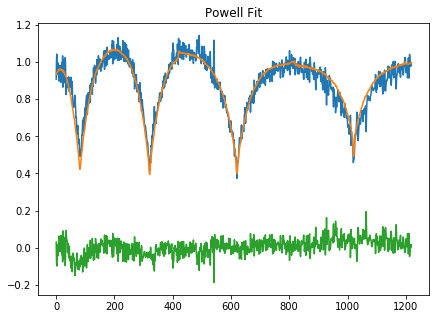

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 106
    # data points      = 1220
    # variables        = 3
    chi-square         = 2.34840200
    reduced chi-square = 0.00192966
    Akaike info crit   = -7622.50267
    Bayesian info crit = -7607.18285
[[Variables]]
    teff:   13000.0046 +/- 3.82131359 (0.03%) (init = 20000)
    logg:   9.46109984 +/- 1.40787497 (14.88%) (init = 8)
    trans:  0.63509909 +/- 0.21216819 (33.41%) (init = 0)

 Starting Bayesian Sampling................
...Done.


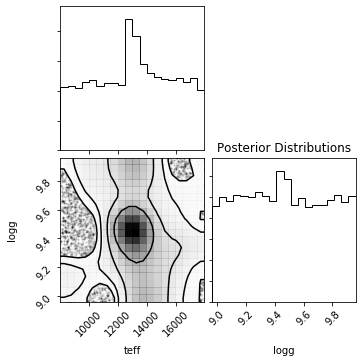

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 2.34861345
    reduced chi-square = 0.00192825
    Akaike info crit   = -7624.39283
    Bayesian info crit = -7614.17961
[[Variables]]
    teff:   13032.4344 +/- 3208.40672 (24.62%) (init = 13000)
    logg:   9.45834426 +/- 0.33801855 (3.57%) (init = 9.4611)
    trans:  0.6350991 (fixed)


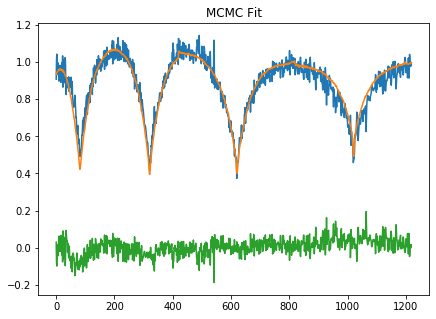




























 32%|███▏      | 18/56 [10:32<21:57, 34.66s/it]

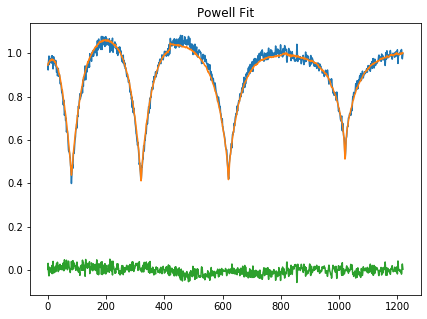

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 429
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.38377110
    reduced chi-square = 3.1534e-04
    Akaike info crit   = -9832.46445
    Bayesian info crit = -9817.14463
##  Warning: uncertainties could not be estimated:
    teff:   at boundary
[[Variables]]
    teff:   13000.0126 +/- 1.42507964 (0.01%) (init = 20000)
    logg:   7.79640581 +/-        nan (nan%) (init = 8)
    trans:  0.14438792 +/- 0.04417058 (30.59%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, trans) =  0.532

 Starting Bayesian Sampling................
...Done.


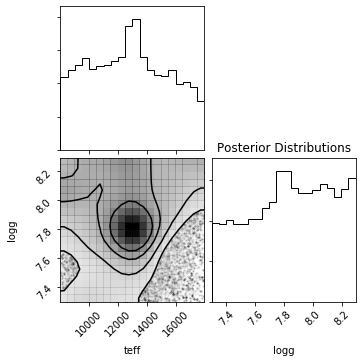

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.45389178
    reduced chi-square = 3.7265e-04
    Akaike info crit   = -9629.73320
    Bayesian info crit = -9619.51999
[[Variables]]
    teff:   12834.5362 +/- 3117.98229 (24.29%) (init = 13000.01)
    logg:   7.84720472 +/- 0.32689185 (4.17%) (init = 7.796406)
    trans:  0.1443879 (fixed)


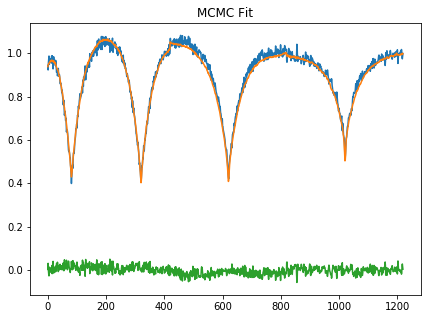




























 34%|███▍      | 19/56 [11:08<21:29, 34.85s/it]

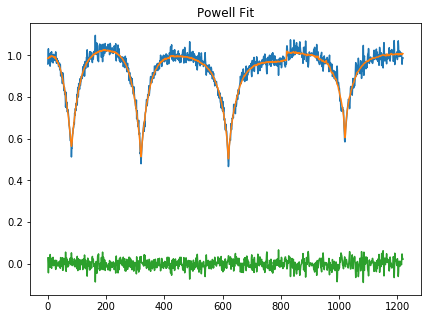

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 107
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.60171646
    reduced chi-square = 4.9443e-04
    Akaike info crit   = -9283.78160
    Bayesian info crit = -9268.46178
[[Variables]]
    teff:   24521.8111 +/- 992.490040 (4.05%) (init = 20000)
    logg:   7.99197583 +/- 0.12357926 (1.55%) (init = 8)
    trans:  0.05856660 +/- 0.10899221 (186.10%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.990

 Starting Bayesian Sampling................
...Done.


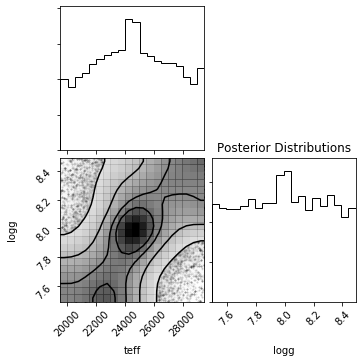

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.60186110
    reduced chi-square = 4.9414e-04
    Akaike info crit   = -9285.48838
    Bayesian info crit = -9275.27516
[[Variables]]
    teff:   24521.6267 +/- 3075.18850 (12.54%) (init = 24521.81)
    logg:   7.99290795 +/- 0.32990585 (4.13%) (init = 7.991976)
    trans:  0.0585666 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.255


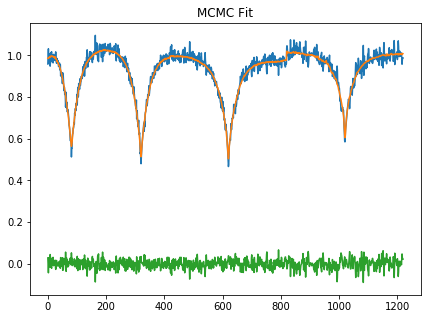




























 36%|███▌      | 20/56 [11:42<20:55, 34.88s/it]

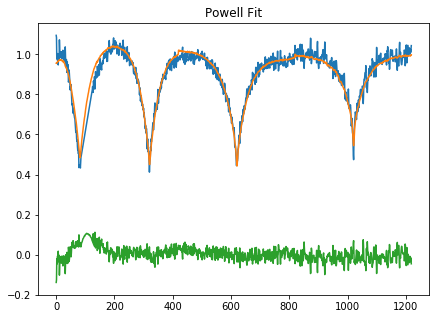

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 97
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.39677056
    reduced chi-square = 0.00114772
    Akaike info crit   = -8256.38084
    Bayesian info crit = -8241.06102
[[Variables]]
    teff:   17986.1900 +/- 334.097571 (1.86%) (init = 20000)
    logg:   8.00299112 +/- 0.04139712 (0.52%) (init = 8)
    trans:  0.52064186 +/- 0.16143780 (31.01%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.942

 Starting Bayesian Sampling................
...Done.


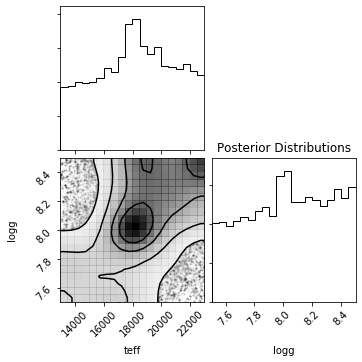

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.39687947
    reduced chi-square = 0.00114686
    Akaike info crit   = -8258.28572
    Bayesian info crit = -8248.07250
[[Variables]]
    teff:   18200.9811 +/- 3125.72870 (17.17%) (init = 17986.19)
    logg:   8.03598394 +/- 0.33321571 (4.15%) (init = 8.002991)
    trans:  0.5206419 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.203


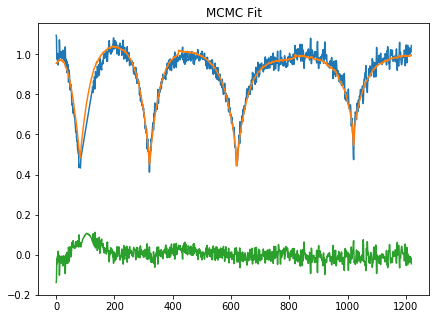




























 38%|███▊      | 21/56 [12:17<20:21, 34.89s/it]

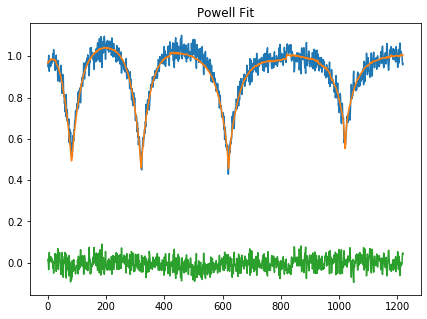

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 372
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.19662219
    reduced chi-square = 9.8326e-04
    Akaike info crit   = -8445.06614
    Bayesian info crit = -8429.74632
[[Variables]]
    teff:   13987.6446 +/- 1099.21398 (7.86%) (init = 20000)
    logg:   7.20313114 +/- 0.19001342 (2.64%) (init = 8)
    trans:  0.41793235 +/- 0.14923552 (35.71%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.982

 Starting Bayesian Sampling................
...Done.


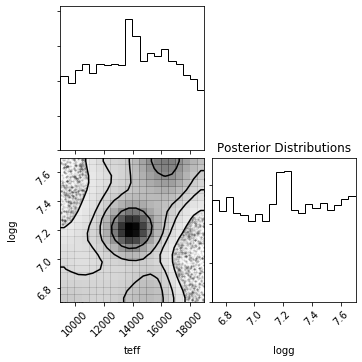

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.19673998
    reduced chi-square = 9.8255e-04
    Akaike info crit   = -8446.94605
    Bayesian info crit = -8436.73284
[[Variables]]
    teff:   13993.9927 +/- 3137.00107 (22.42%) (init = 13987.64)
    logg:   7.20664553 +/- 0.34529703 (4.79%) (init = 7.203131)
    trans:  0.4179323 (fixed)


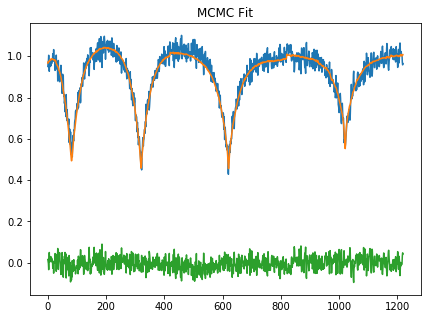




























 39%|███▉      | 22/56 [12:52<19:47, 34.93s/it]

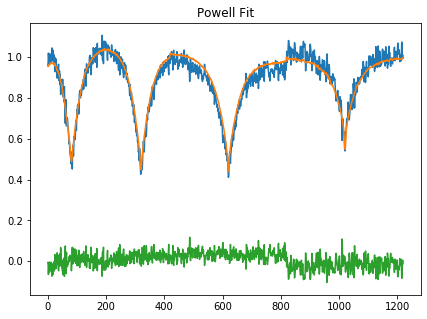

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 215
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.61860754
    reduced chi-square = 0.00133000
    Akaike info crit   = -8076.54868
    Bayesian info crit = -8061.22886
[[Variables]]
    teff:   18764.2085 +/- 206.746136 (1.10%) (init = 20000)
    logg:   8.19545139 +/- 0.07733046 (0.94%) (init = 8)
    trans:  0.03377055 +/- 0.22148789 (655.86%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.646

 Starting Bayesian Sampling................
...Done.


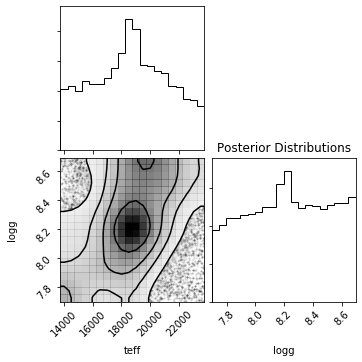

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.61893802
    reduced chi-square = 0.00132918
    Akaike info crit   = -8078.29961
    Bayesian info crit = -8068.08640
[[Variables]]
    teff:   18734.5379 +/- 2950.93979 (15.75%) (init = 18764.21)
    logg:   8.21263219 +/- 0.32972466 (4.01%) (init = 8.195451)
    trans:  0.03377055 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.169


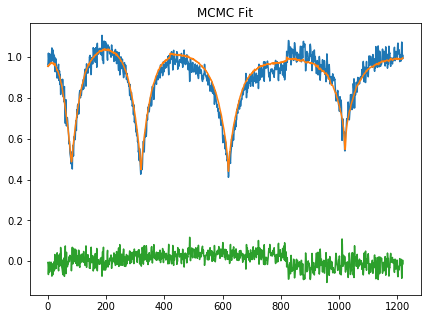




























 41%|████      | 23/56 [13:28<19:23, 35.25s/it]

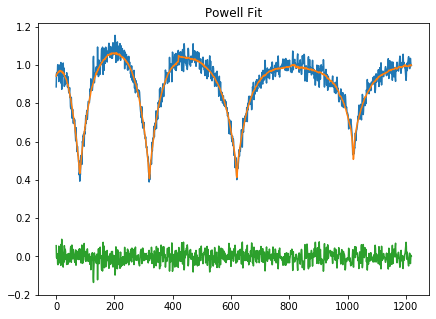

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 386
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.12264274
    reduced chi-square = 9.2247e-04
    Akaike info crit   = -8522.92319
    Bayesian info crit = -8507.60337
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   13037.5315 +/- 8.06110693 (0.06%) (init = 20000)
    logg:   7.82037865 +/-        nan (nan%) (init = 8)
    trans:  0.06949296 +/- 0.13105622 (188.59%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, trans) =  1.047

 Starting Bayesian Sampling................
...Done.


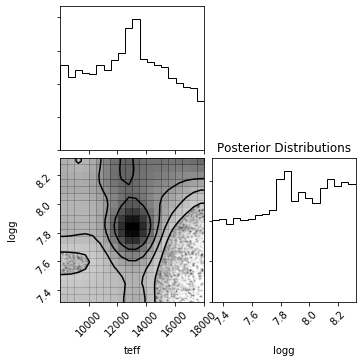

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.15945453
    reduced chi-square = 9.5193e-04
    Akaike info crit   = -8485.56090
    Bayesian info crit = -8475.34769
[[Variables]]
    teff:   12944.3974 +/- 3103.41759 (23.97%) (init = 13037.53)
    logg:   7.86863689 +/- 0.33337764 (4.24%) (init = 7.820379)
    trans:  0.06949296 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.102


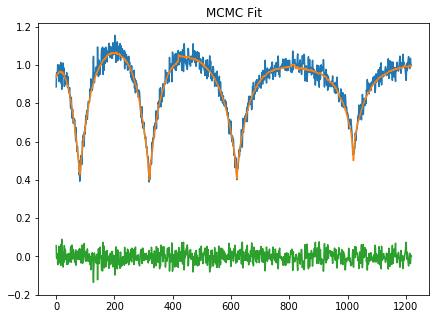




























 43%|████▎     | 24/56 [14:04<18:52, 35.38s/it]

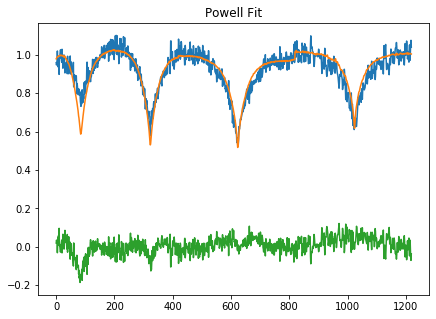

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 346
    # data points      = 1220
    # variables        = 3
    chi-square         = 2.34210240
    reduced chi-square = 0.00192449
    Akaike info crit   = -7625.77973
    Bayesian info crit = -7610.45991
[[Variables]]
    teff:   36061.9354 +/- 735.850029 (2.04%) (init = 20000)
    logg:   9.49966251 +/- 0.01895292 (0.20%) (init = 8)
    trans:  3.38314073 +/- 0.29109595 (8.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.159

 Starting Bayesian Sampling................
...Done.


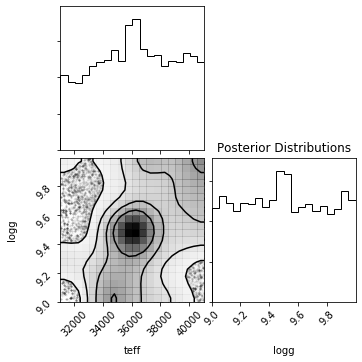

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 2.34222705
    reduced chi-square = 0.00192301
    Akaike info crit   = -7627.71479
    Bayesian info crit = -7617.50158
[[Variables]]
    teff:   36173.3773 +/- 3204.98794 (8.86%) (init = 36061.94)
    logg:   9.49785314 +/- 0.34026931 (3.58%) (init = 9.499663)
    trans:  3.383141 (fixed)


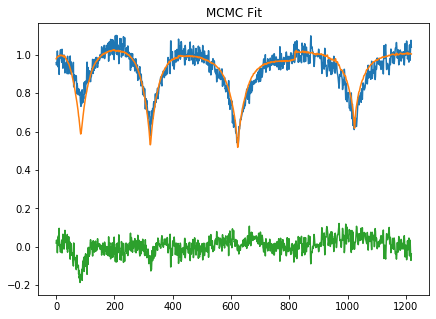




























 45%|████▍     | 25/56 [14:40<18:16, 35.39s/it]

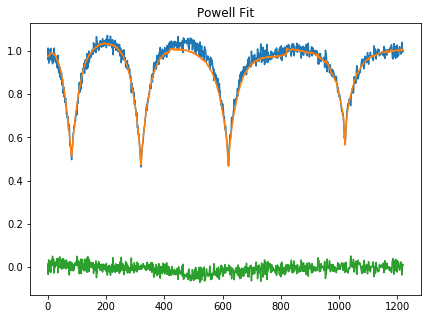

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 406
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.61576624
    reduced chi-square = 5.0597e-04
    Akaike info crit   = -9255.62269
    Bayesian info crit = -9240.30287
[[Variables]]
    teff:   13022.7190 +/- 162.979794 (1.25%) (init = 20000)
    logg:   6.64470693 +/- 0.04791269 (0.72%) (init = 8)
    trans: -0.02797365 +/- 0.11156439 (398.82%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.745

 Starting Bayesian Sampling................
...Done.


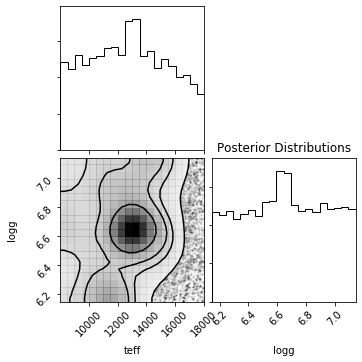

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.61610258
    reduced chi-square = 5.0583e-04
    Akaike info crit   = -9256.95649
    Bayesian info crit = -9246.74328
[[Variables]]
    teff:   12899.8703 +/- 3113.36847 (24.13%) (init = 13022.72)
    logg:   6.64600106 +/- 0.33307387 (5.01%) (init = 6.644707)
    trans: -0.02797365 (fixed)


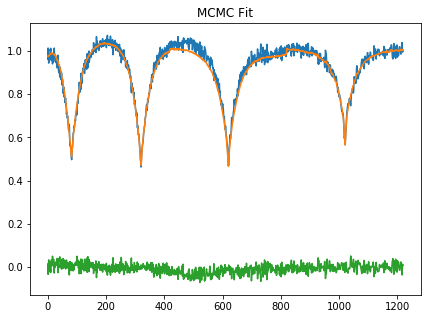




























 46%|████▋     | 26/56 [15:15<17:45, 35.52s/it]

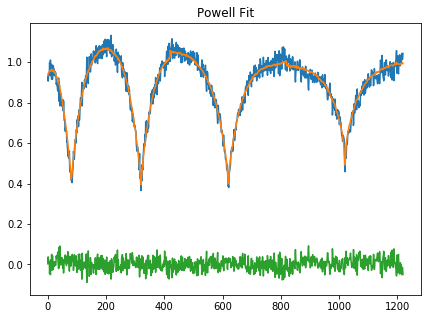

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 88
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.99450026
    reduced chi-square = 8.1717e-04
    Akaike info crit   = -8670.78769
    Bayesian info crit = -8655.46787
[[Variables]]
    teff:   13000.0043 +/- 1.53176981 (0.01%) (init = 20000)
    logg:   9.49952456 +/- 0.09040383 (0.95%) (init = 8)
    trans: -0.29393472 +/- 0.12217885 (41.57%) (init = 0)

 Starting Bayesian Sampling................
...Done.


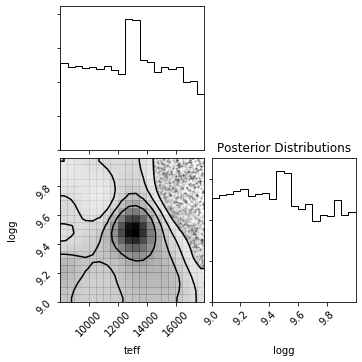

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.99461194
    reduced chi-square = 8.1659e-04
    Akaike info crit   = -8672.65069
    Bayesian info crit = -8662.43748
[[Variables]]
    teff:   12989.4010 +/- 3219.95124 (24.79%) (init = 13000)
    logg:   9.47360656 +/- 0.33614849 (3.55%) (init = 9.499525)
    trans: -0.2939347 (fixed)


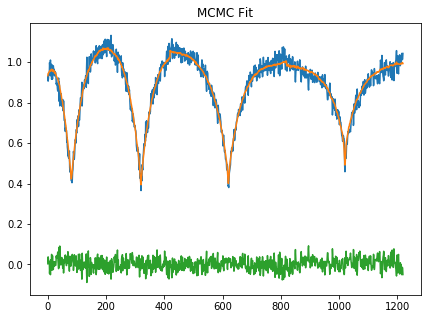




























 48%|████▊     | 27/56 [15:50<17:04, 35.34s/it]

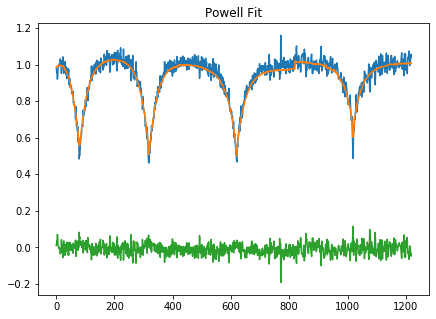

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 421
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.14538734
    reduced chi-square = 9.4116e-04
    Akaike info crit   = -8498.45319
    Bayesian info crit = -8483.13337
[[Variables]]
    teff:   17458.0267 +/- 3303.25328 (18.92%) (init = 20000)
    logg:   6.87189419 +/- 0.64080893 (9.33%) (init = 8)
    trans: -0.83374530 +/- 0.15262435 (18.31%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.998

 Starting Bayesian Sampling................
...Done.


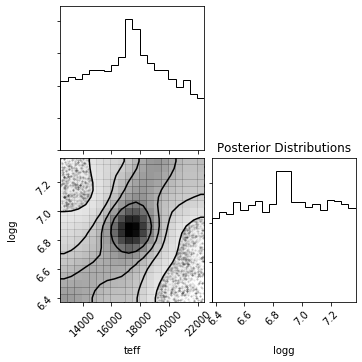

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.14565356
    reduced chi-square = 9.4060e-04
    Akaike info crit   = -8500.16966
    Bayesian info crit = -8489.95644
[[Variables]]
    teff:   17441.5503 +/- 3050.09063 (17.49%) (init = 17458.03)
    logg:   6.87457930 +/- 0.33136494 (4.82%) (init = 6.871894)
    trans: -0.8337453 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.181


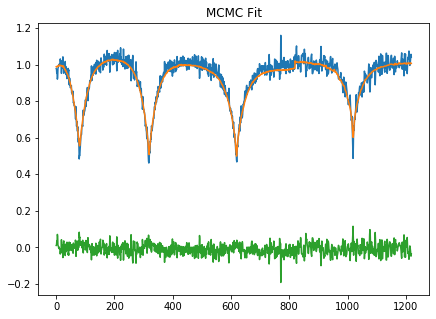




























 50%|█████     | 28/56 [16:26<16:34, 35.50s/it]

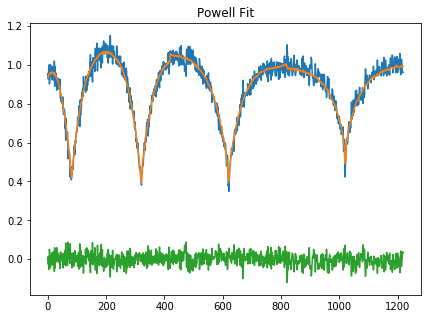

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 133
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.11812828
    reduced chi-square = 9.1876e-04
    Akaike info crit   = -8527.83904
    Bayesian info crit = -8512.51922
[[Variables]]
    teff:   13000.0002 +/- 2.93376920 (0.02%) (init = 20000)
    logg:   9.49987366 +/- 0.04585179 (0.48%) (init = 8)
    trans:  0.05236816 +/- 0.11823302 (225.77%) (init = 0)

 Starting Bayesian Sampling................
...Done.


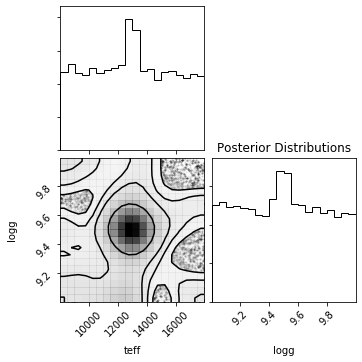

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.11833023
    reduced chi-square = 9.1817e-04
    Akaike info crit   = -8529.61870
    Bayesian info crit = -8519.40549
[[Variables]]
    teff:   12987.6298 +/- 3286.30775 (25.30%) (init = 13000)
    logg:   9.49789123 +/- 0.33322256 (3.51%) (init = 9.499874)
    trans:  0.05236816 (fixed)


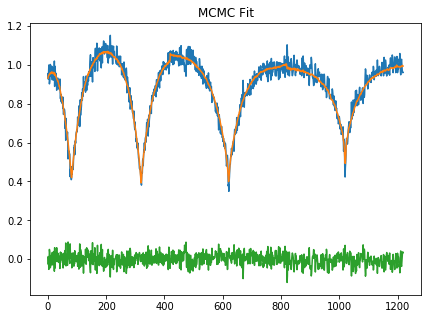




























 52%|█████▏    | 29/56 [17:01<15:49, 35.17s/it]

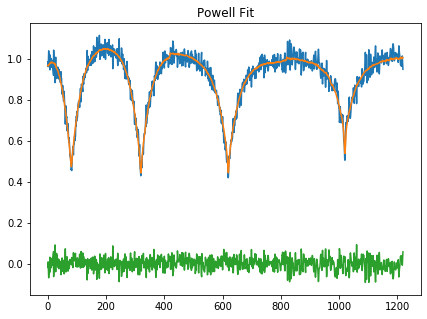

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 284
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.05660485
    reduced chi-square = 8.6820e-04
    Akaike info crit   = -8596.88532
    Bayesian info crit = -8581.56550
[[Variables]]
    teff:   15788.2980 +/- 468.744553 (2.97%) (init = 20000)
    logg:   7.78500178 +/- 0.04281966 (0.55%) (init = 8)
    trans: -0.33127142 +/- 0.13796518 (41.65%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.967

 Starting Bayesian Sampling................
...Done.


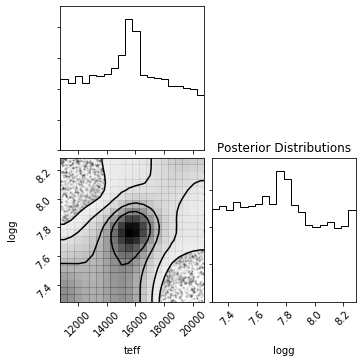

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.05771035
    reduced chi-square = 8.6840e-04
    Akaike info crit   = -8597.60952
    Bayesian info crit = -8587.39631
[[Variables]]
    teff:   15690.8251 +/- 3130.66568 (19.95%) (init = 15788.3)
    logg:   7.76196081 +/- 0.32922309 (4.24%) (init = 7.785002)
    trans: -0.3312714 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.168


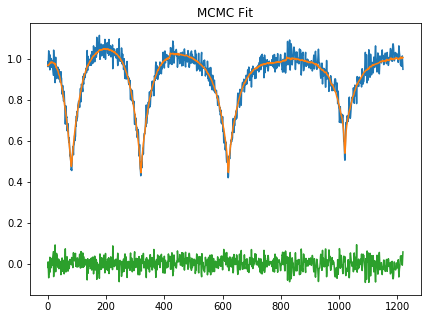




























 54%|█████▎    | 30/56 [17:36<15:14, 35.17s/it]

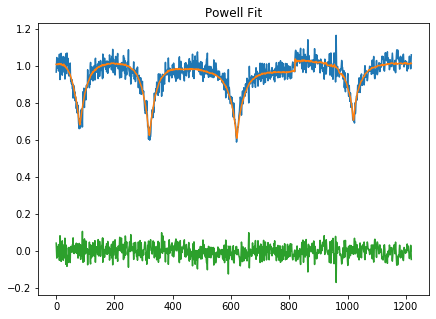

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 138
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.35509402
    reduced chi-square = 0.00111347
    Akaike info crit   = -8293.33706
    Bayesian info crit = -8278.01725
[[Variables]]
    teff:   32950.4212 +/- 3420.04279 (10.38%) (init = 20000)
    logg:   8.00279679 +/- 0.20072701 (2.51%) (init = 8)
    trans: -0.01897229 +/- 0.16495583 (869.46%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.999

 Starting Bayesian Sampling................
...Done.


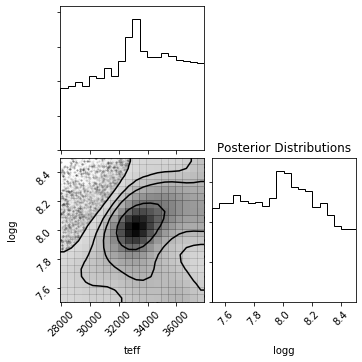

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.36117186
    reduced chi-square = 0.00111755
    Akaike info crit   = -8289.87738
    Bayesian info crit = -8279.66417
[[Variables]]
    teff:   33289.3271 +/- 3168.62676 (9.52%) (init = 32950.42)
    logg:   7.99715332 +/- 0.31521217 (3.94%) (init = 8.002797)
    trans: -0.01897229 (fixed)


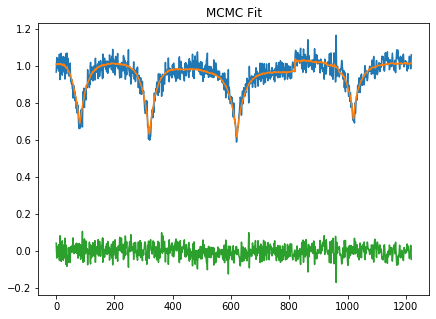




























 55%|█████▌    | 31/56 [18:11<14:38, 35.15s/it]

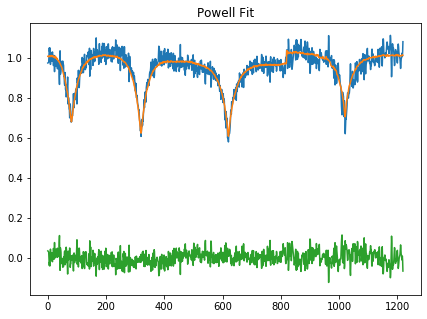

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 166
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.31430227
    reduced chi-square = 0.00107995
    Akaike info crit   = -8330.62625
    Bayesian info crit = -8315.30644
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   32798.8749 +/-        nan (nan%) (init = 20000)
    logg:   7.99706258 +/-        nan (nan%) (init = 8)
    trans:  0.02311934 +/- 0.18385312 (795.24%) (init = 0)

 Starting Bayesian Sampling................
...Done.


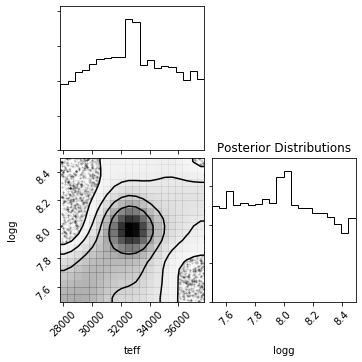

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.31706996
    reduced chi-square = 0.00108134
    Akaike info crit   = -8330.05985
    Bayesian info crit = -8319.84663
[[Variables]]
    teff:   32789.0173 +/- 3133.06785 (9.56%) (init = 32798.87)
    logg:   7.97945778 +/- 0.32647065 (4.09%) (init = 7.997063)
    trans:  0.02311934 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.107


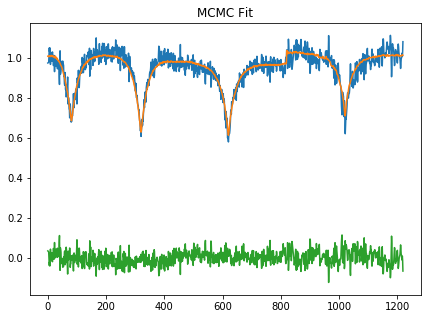




























 57%|█████▋    | 32/56 [18:46<14:00, 35.02s/it]

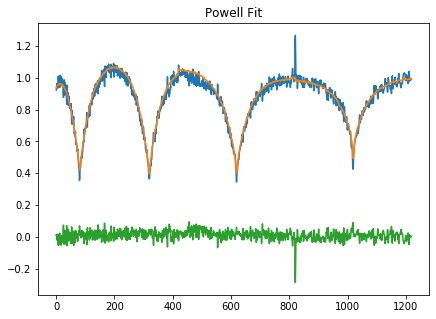

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 96
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.12881621
    reduced chi-square = 9.2754e-04
    Akaike info crit   = -8516.23272
    Bayesian info crit = -8500.91290
[[Variables]]
    teff:   13000.0096 +/- 3.78854972 (0.03%) (init = 20000)
    logg:   8.15099190 +/- 0.13069478 (1.60%) (init = 8)
    trans: -0.50159157 +/- 0.13003578 (25.92%) (init = 0)

 Starting Bayesian Sampling................
...Done.


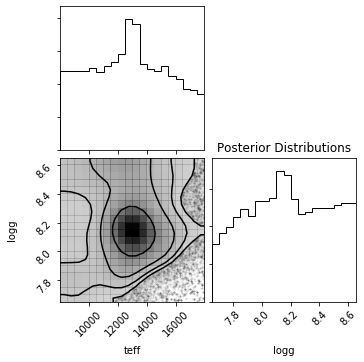

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.12876794
    reduced chi-square = 9.2674e-04
    Akaike info crit   = -8518.28489
    Bayesian info crit = -8508.07168
[[Variables]]
    teff:   12899.1038 +/- 3129.23740 (24.26%) (init = 13000.01)
    logg:   8.16162844 +/- 0.32033393 (3.92%) (init = 8.150992)
    trans: -0.5015916 (fixed)


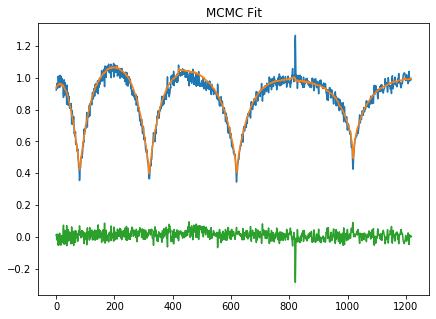




























 59%|█████▉    | 33/56 [19:20<13:24, 34.98s/it]

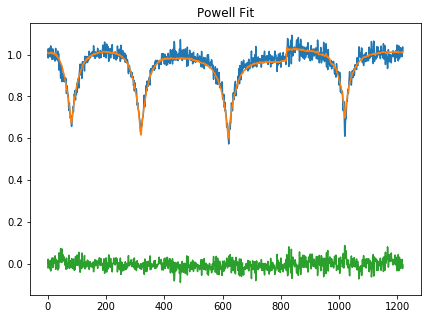

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 124
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.69438929
    reduced chi-square = 5.7057e-04
    Akaike info crit   = -9109.02099
    Bayesian info crit = -9093.70117
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   32427.0005 +/-        nan (nan%) (init = 20000)
    logg:   8.00036406 +/-        nan (nan%) (init = 8)
    trans: -0.21778268 +/- 0.15410448 (70.76%) (init = 0)

 Starting Bayesian Sampling................
...Done.


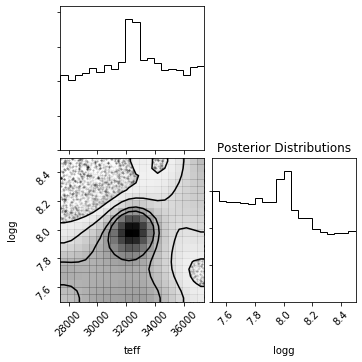

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.71392320
    reduced chi-square = 5.8614e-04
    Akaike info crit   = -9077.17494
    Bayesian info crit = -9066.96173
[[Variables]]
    teff:   32444.1999 +/- 3227.97829 (9.95%) (init = 32427)
    logg:   7.95529381 +/- 0.32467035 (4.08%) (init = 8.000364)
    trans: -0.2177827 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.133


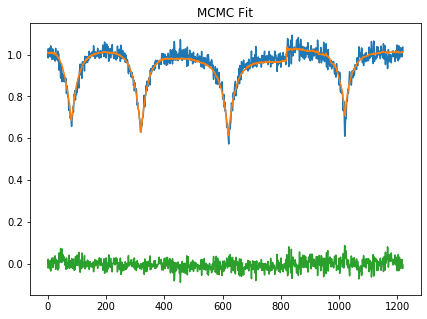




























 61%|██████    | 34/56 [19:56<12:50, 35.01s/it]

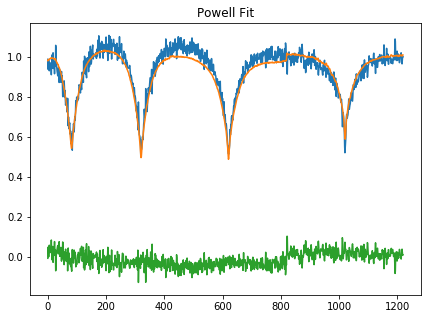

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 184
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.76193580
    reduced chi-square = 0.00144777
    Akaike info crit   = -7973.03552
    Bayesian info crit = -7957.71570
[[Variables]]
    teff:   22428.3389 +/- 645.495814 (2.88%) (init = 20000)
    logg:   7.94788755 +/- 0.07238802 (0.91%) (init = 8)
    trans:  0.38972522 +/- 0.19207108 (49.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.917

 Starting Bayesian Sampling................
...Done.


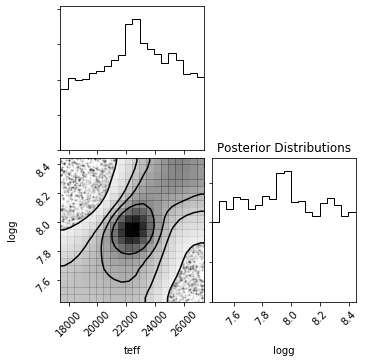

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.76163273
    reduced chi-square = 0.00144633
    Akaike info crit   = -7975.24539
    Bayesian info crit = -7965.03217
[[Variables]]
    teff:   22579.7904 +/- 3097.64712 (13.72%) (init = 22428.34)
    logg:   7.94620235 +/- 0.32817424 (4.13%) (init = 7.947888)
    trans:  0.3897252 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.208


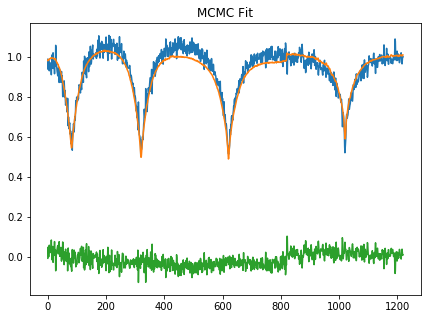




























 62%|██████▎   | 35/56 [20:31<12:18, 35.19s/it]

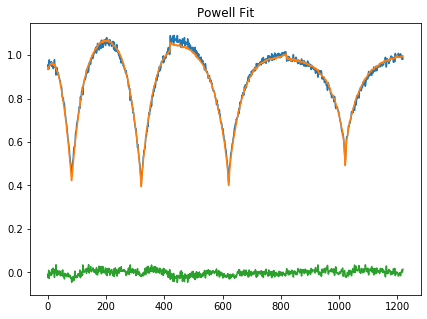

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 127
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.22078041
    reduced chi-square = 1.8141e-04
    Akaike info crit   = -10506.9752
    Bayesian info crit = -10491.6554
[[Variables]]
    teff:   13000.0001 +/- 0.75416946 (0.01%) (init = 20000)
    logg:   9.49999946 +/- 0.00145964 (0.02%) (init = 8)
    trans:  0.66639080 +/- 0.06532712 (9.80%) (init = 0)

 Starting Bayesian Sampling................
...Done.


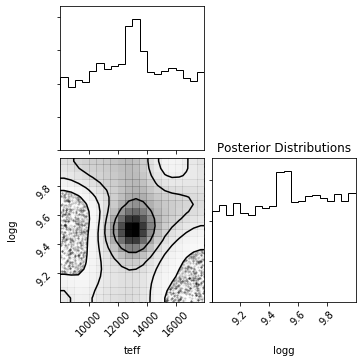

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.22090811
    reduced chi-square = 1.8137e-04
    Akaike info crit   = -10508.2698
    Bayesian info crit = -10498.0566
[[Variables]]
    teff:   13004.4921 +/- 3146.25159 (24.19%) (init = 13000)
    logg:   9.51543159 +/- 0.33712368 (3.54%) (init = 9.499999)
    trans:  0.6663908 (fixed)


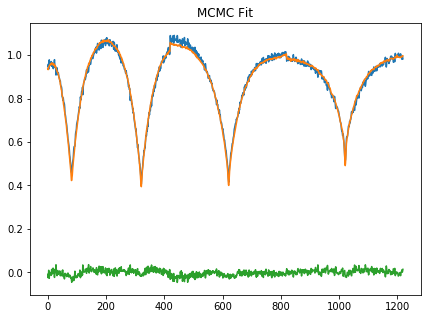




























 64%|██████▍   | 36/56 [21:06<11:43, 35.16s/it]

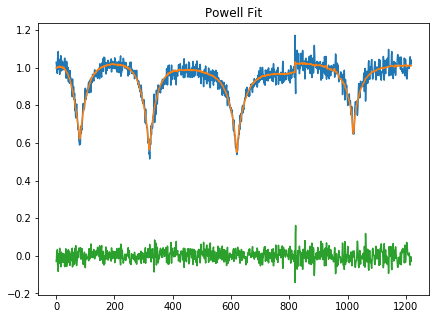

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 115
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.07772274
    reduced chi-square = 8.8556e-04
    Akaike info crit   = -8572.74220
    Bayesian info crit = -8557.42238
[[Variables]]
    teff:   29425.6244 +/- 3084.73007 (10.48%) (init = 20000)
    logg:   8.00443639 +/- 0.21128882 (2.64%) (init = 8)
    trans: -0.20969953 +/- 0.14902547 (71.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.998

 Starting Bayesian Sampling................
...Done.


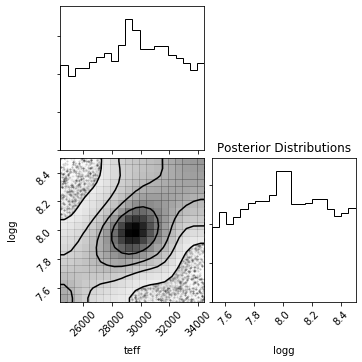

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.07782304
    reduced chi-square = 8.8491e-04
    Akaike info crit   = -8574.62866
    Bayesian info crit = -8564.41545
[[Variables]]
    teff:   29468.7365 +/- 3187.09467 (10.82%) (init = 29425.62)
    logg:   8.00740709 +/- 0.32043343 (4.00%) (init = 8.004436)
    trans: -0.2096995 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.148


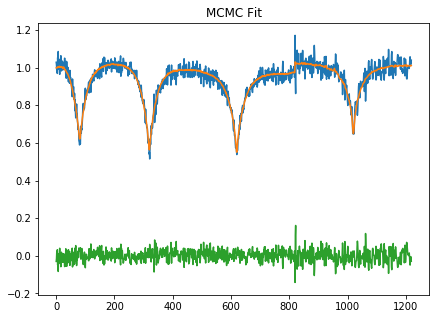




























 66%|██████▌   | 37/56 [21:42<11:08, 35.20s/it]

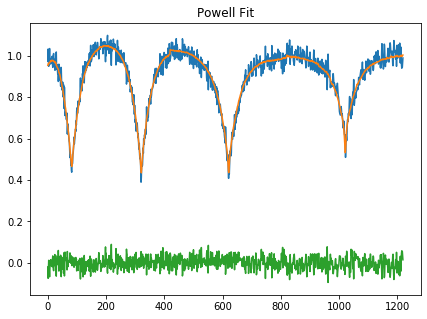

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 262
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.00696318
    reduced chi-square = 8.2741e-04
    Akaike info crit   = -8655.59385
    Bayesian info crit = -8640.27403
[[Variables]]
    teff:   15947.4788 +/- 324.626249 (2.04%) (init = 20000)
    logg:   7.84255532 +/- 0.02033551 (0.26%) (init = 8)
    trans:  0.88083887 +/- 0.15656354 (17.77%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg)  =  0.962
    C(logg, trans) = -0.117
    C(teff, trans) = -0.110

 Starting Bayesian Sampling................
...Done.


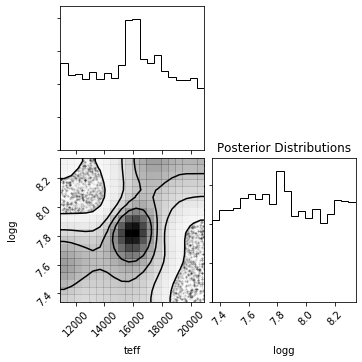

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.00889986
    reduced chi-square = 8.2833e-04
    Akaike info crit   = -8655.24969
    Bayesian info crit = -8645.03648
[[Variables]]
    teff:   15948.1515 +/- 3205.08200 (20.10%) (init = 15947.48)
    logg:   7.83416186 +/- 0.33709458 (4.30%) (init = 7.842555)
    trans:  0.8808389 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.137


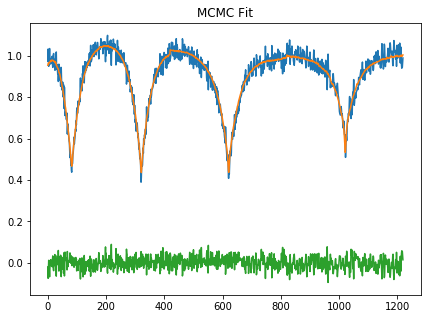




























 68%|██████▊   | 38/56 [22:17<10:32, 35.16s/it]

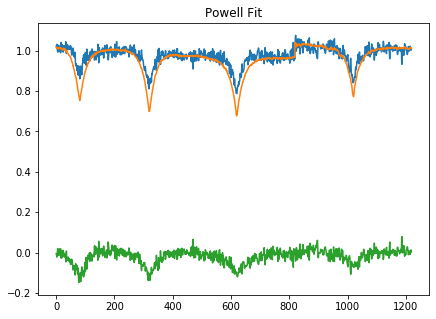

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 136
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.97131639
    reduced chi-square = 0.00161982
    Akaike info crit   = -7836.04361
    Bayesian info crit = -7820.72379
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   76970.5812 (init = 20000)
    logg:   7.14561406 (init = 8)
    trans: -0.11898246 (init = 0)

 Starting Bayesian Sampling................
...Done.


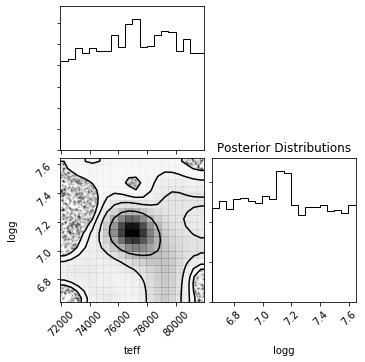

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.97136579
    reduced chi-square = 0.00161853
    Akaike info crit   = -7838.01304
    Bayesian info crit = -7827.79983
[[Variables]]
    teff:   77045.2604 +/- 3267.52308 (4.24%) (init = 76970.58)
    logg:   7.13877439 +/- 0.33352500 (4.67%) (init = 7.145614)
    trans: -0.1189825 (fixed)


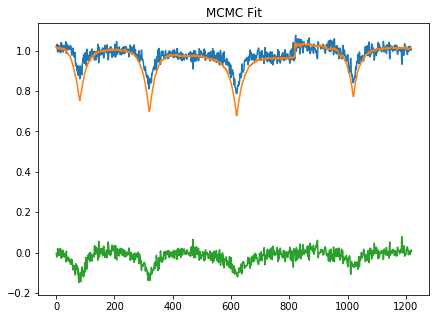




























 70%|██████▉   | 39/56 [22:51<09:53, 34.88s/it]

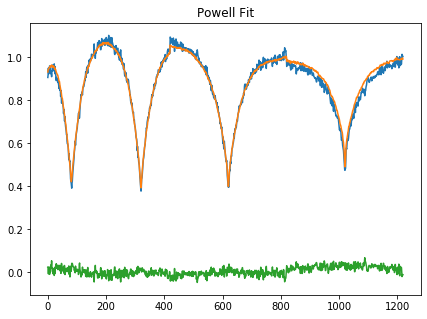

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 125
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.50323822
    reduced chi-square = 4.1351e-04
    Akaike info crit   = -9501.82327
    Bayesian info crit = -9486.50345
[[Variables]]
    teff:   13000.0053 +/- 0.90346031 (0.01%) (init = 20000)
    logg:   9.49770675 +/- 0.17912926 (1.89%) (init = 8)
    trans: -0.24994315 +/- 0.09392216 (37.58%) (init = 0)

 Starting Bayesian Sampling................
...Done.


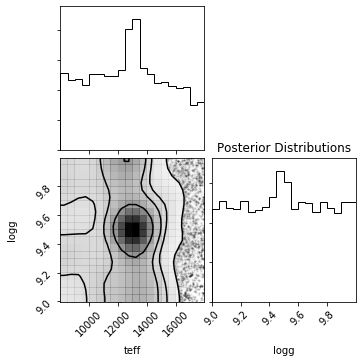

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.50274638
    reduced chi-square = 4.1276e-04
    Akaike info crit   = -9505.01621
    Bayesian info crit = -9494.80299
[[Variables]]
    teff:   12937.8218 +/- 3110.46039 (24.04%) (init = 13000.01)
    logg:   9.49729918 +/- 0.33553620 (3.53%) (init = 9.497707)
    trans: -0.2499431 (fixed)


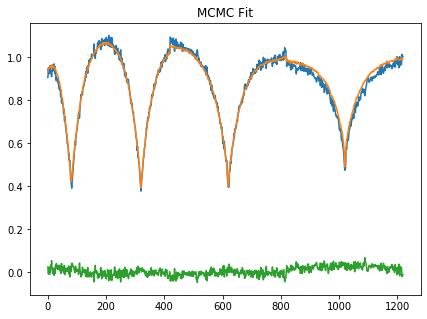




























 71%|███████▏  | 40/56 [23:26<09:17, 34.83s/it]

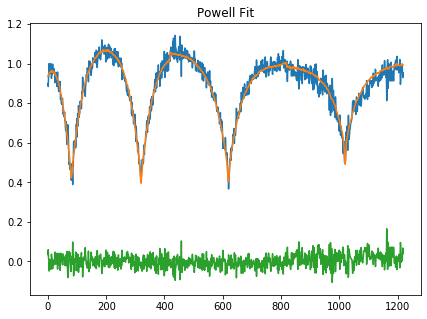

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 113
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.26845678
    reduced chi-square = 0.00104228
    Akaike info crit   = -8373.94224
    Bayesian info crit = -8358.62242
[[Variables]]
    teff:   13000.0045 +/- 2.35961075 (0.02%) (init = 20000)
    logg:   9.49875499 +/- 0.53675356 (5.65%) (init = 8)
    trans: -0.42876086 +/- 0.13471716 (31.42%) (init = 0)

 Starting Bayesian Sampling................
...Done.


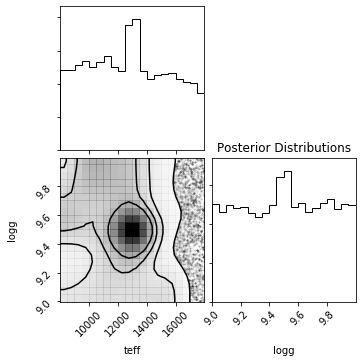

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.26819258
    reduced chi-square = 0.00104121
    Akaike info crit   = -8376.19636
    Bayesian info crit = -8365.98315
[[Variables]]
    teff:   12861.3603 +/- 3208.13585 (24.94%) (init = 13000)
    logg:   9.50115710 +/- 0.33844852 (3.56%) (init = 9.498755)
    trans: -0.4287609 (fixed)


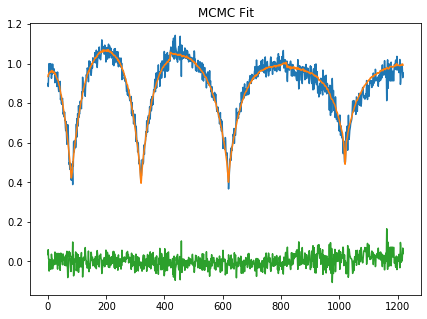




























 73%|███████▎  | 41/56 [24:00<08:41, 34.80s/it]

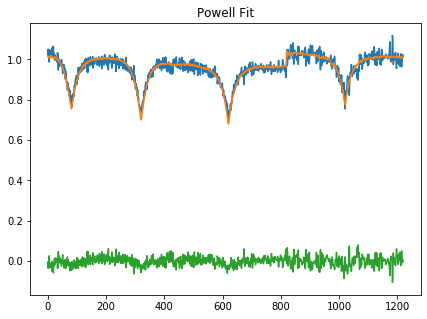

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 148
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.64462265
    reduced chi-square = 5.2968e-04
    Akaike info crit   = -9199.74950
    Bayesian info crit = -9184.42968
[[Variables]]
    teff:   79976.5937 +/- 390.275806 (0.49%) (init = 20000)
    logg:   9.40860590 +/- 0.05871503 (0.62%) (init = 8)
    trans:  0.10641946 +/- 0.20015302 (188.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.219

 Starting Bayesian Sampling................
...Done.


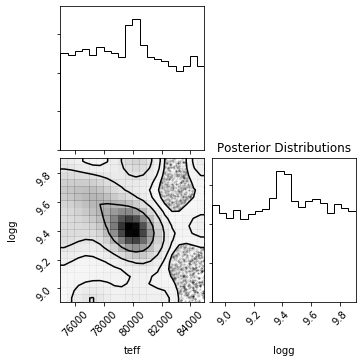

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.64469659
    reduced chi-square = 5.2931e-04
    Akaike info crit   = -9201.60958
    Bayesian info crit = -9191.39636
[[Variables]]
    teff:   79903.3576 +/- 3313.47528 (4.15%) (init = 79976.59)
    logg:   9.41229758 +/- 0.33218163 (3.53%) (init = 9.408606)
    trans:  0.1064195 (fixed)


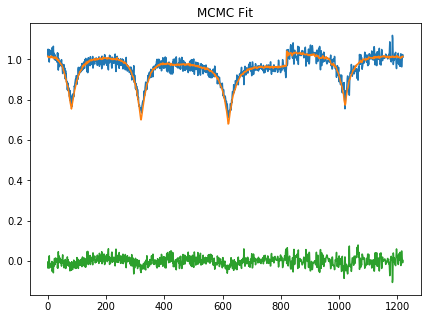




























 75%|███████▌  | 42/56 [24:35<08:05, 34.69s/it]

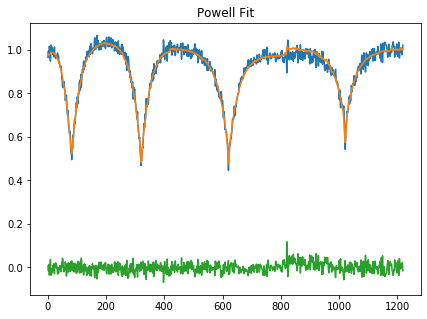

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 109
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.53460240
    reduced chi-square = 4.3928e-04
    Akaike info crit   = -9428.06250
    Bayesian info crit = -9412.74268
[[Variables]]
    teff:   21446.2799 +/- 719.782119 (3.36%) (init = 20000)
    logg:   7.99982533 +/- 0.05680991 (0.71%) (init = 8)
    trans:  0.66964737 +/- 0.10247232 (15.30%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.989

 Starting Bayesian Sampling................
...Done.


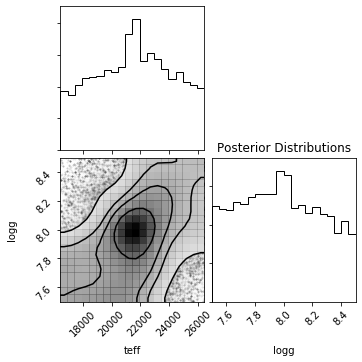

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.53916209
    reduced chi-square = 4.4266e-04
    Akaike info crit   = -9419.70110
    Bayesian info crit = -9409.48789
[[Variables]]
    teff:   21514.8034 +/- 3064.54769 (14.24%) (init = 21446.28)
    logg:   7.97645528 +/- 0.31648149 (3.97%) (init = 7.999825)
    trans:  0.6696474 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.211


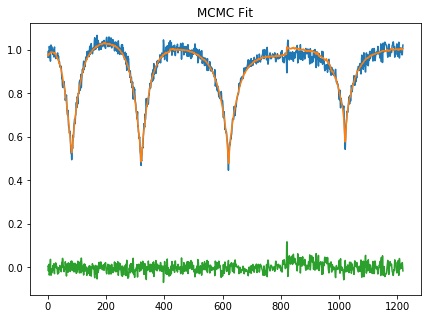




























 77%|███████▋  | 43/56 [25:10<07:33, 34.87s/it]

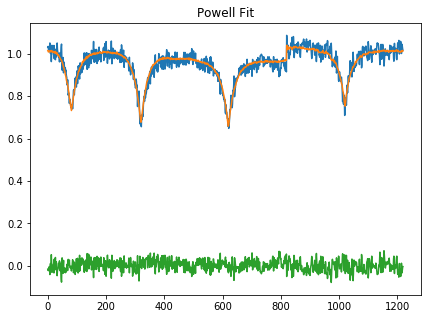

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 136
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.74186835
    reduced chi-square = 6.0959e-04
    Akaike info crit   = -9028.33133
    Bayesian info crit = -9013.01151
[[Variables]]
    teff:   37102.3180 +/- 7192.82779 (19.39%) (init = 20000)
    logg:   8.00305312 +/- 0.40950733 (5.12%) (init = 8)
    trans: -0.10798780 +/- 0.19144835 (177.29%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.999

 Starting Bayesian Sampling................
...Done.


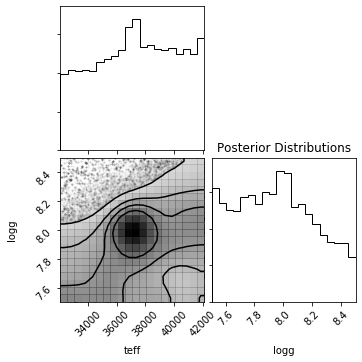

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.74680703
    reduced chi-square = 6.1314e-04
    Akaike info crit   = -9022.23661
    Bayesian info crit = -9012.02339
[[Variables]]
    teff:   37347.0905 +/- 3285.03938 (8.80%) (init = 37102.32)
    logg:   7.94969981 +/- 0.30364524 (3.82%) (init = 8.003053)
    trans: -0.1079878 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.146


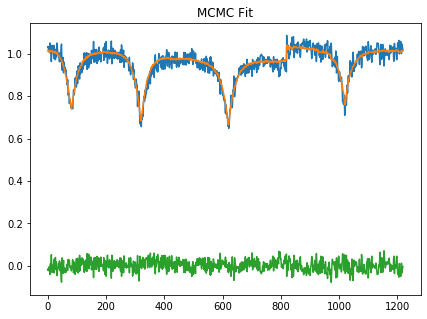




























 79%|███████▊  | 44/56 [25:45<06:58, 34.88s/it]

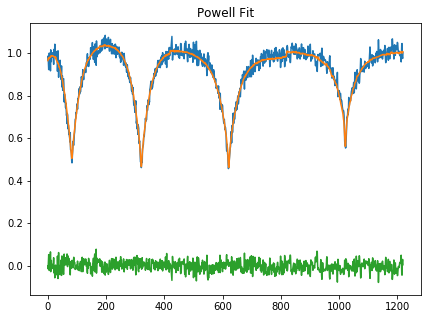

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 394
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.66856107
    reduced chi-square = 5.4935e-04
    Akaike info crit   = -9155.26507
    Bayesian info crit = -9139.94525
[[Variables]]
    teff:   14339.8100 +/- 1667.45459 (11.63%) (init = 20000)
    logg:   7.07173803 +/- 0.36251188 (5.13%) (init = 8)
    trans:  1.15128888 +/- 0.11734477 (10.19%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.996

 Starting Bayesian Sampling................
...Done.


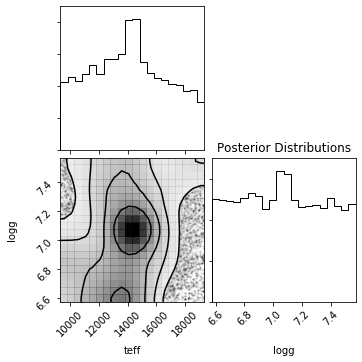

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.66895593
    reduced chi-square = 5.4922e-04
    Akaike info crit   = -9156.54474
    Bayesian info crit = -9146.33153
[[Variables]]
    teff:   14176.1784 +/- 3029.11811 (21.37%) (init = 14339.81)
    logg:   7.06806360 +/- 0.33546740 (4.75%) (init = 7.071738)
    trans:  1.151289 (fixed)


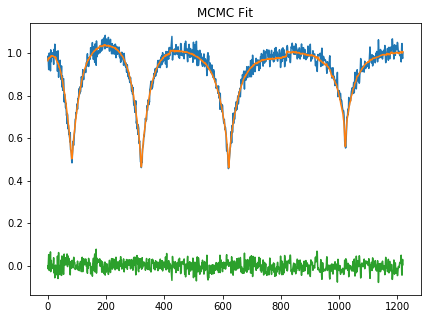




























 80%|████████  | 45/56 [26:21<06:26, 35.16s/it]

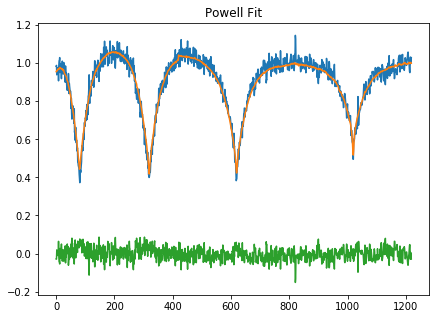

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 354
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.25749816
    reduced chi-square = 0.00103328
    Akaike info crit   = -8384.52802
    Bayesian info crit = -8369.20820
[[Variables]]
    teff:   13000.1009 +/- 6.28683078 (0.05%) (init = 20000)
    logg:   7.76641882 +/- 0.00620699 (0.08%) (init = 8)
    trans: -0.62942829 +/- 0.13619065 (21.64%) (init = 0)

 Starting Bayesian Sampling................
...Done.


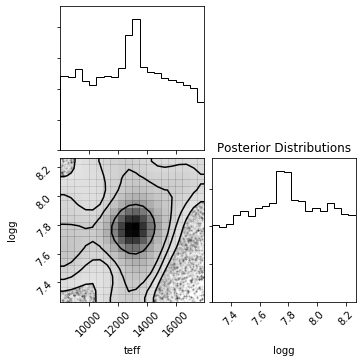

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.25832458
    reduced chi-square = 0.00103311
    Akaike info crit   = -8385.72650
    Bayesian info crit = -8375.51329
[[Variables]]
    teff:   12995.0663 +/- 3203.43519 (24.65%) (init = 13000.1)
    logg:   7.77185375 +/- 0.32105850 (4.13%) (init = 7.766419)
    trans: -0.6294283 (fixed)


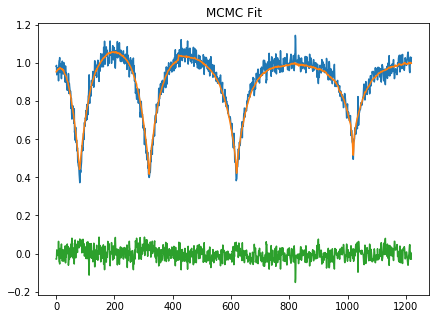




























 82%|████████▏ | 46/56 [26:57<05:54, 35.46s/it]

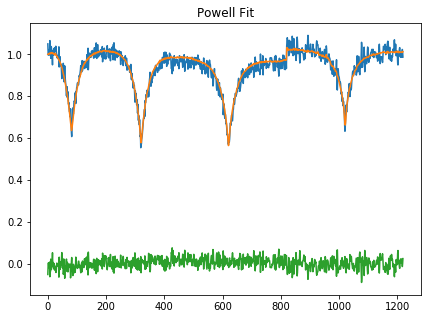

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 118
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.74094523
    reduced chi-square = 6.0883e-04
    Akaike info crit   = -9029.85034
    Bayesian info crit = -9014.53052
[[Variables]]
    teff:   30430.8669 +/- 4481.09378 (14.73%) (init = 20000)
    logg:   8.00210643 +/- 0.28714924 (3.59%) (init = 8)
    trans:  0.42520105 +/- 0.14588401 (34.31%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg)  =  1.000
    C(logg, trans) = -0.139
    C(teff, trans) = -0.139

 Starting Bayesian Sampling................
...Done.


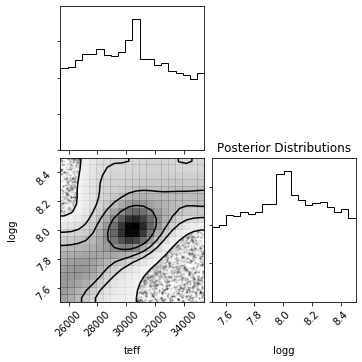

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.74376950
    reduced chi-square = 6.1065e-04
    Akaike info crit   = -9027.20890
    Bayesian info crit = -9016.99569
[[Variables]]
    teff:   30281.6097 +/- 3197.36848 (10.56%) (init = 30430.87)
    logg:   8.01268608 +/- 0.32184521 (4.02%) (init = 8.002106)
    trans:  0.425201 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.161


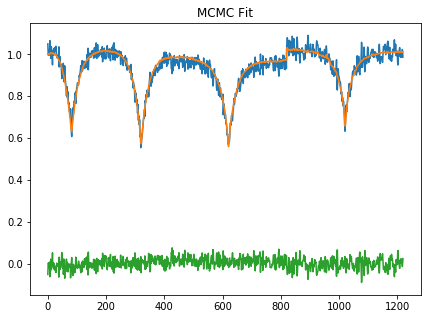




























 84%|████████▍ | 47/56 [27:32<05:19, 35.45s/it]

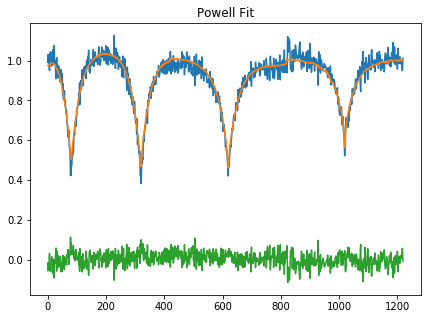

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 202
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.31679546
    reduced chi-square = 0.00108200
    Akaike info crit   = -8328.31414
    Bayesian info crit = -8312.99432
[[Variables]]
    teff:   18052.6381 +/- 377.298954 (2.09%) (init = 20000)
    logg:   7.83829991 +/- 0.03854885 (0.49%) (init = 8)
    trans: -0.72682715 +/- 0.14937932 (20.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg)  =  0.913
    C(logg, trans) = -0.107
    C(teff, trans) = -0.102

 Starting Bayesian Sampling................
...Done.


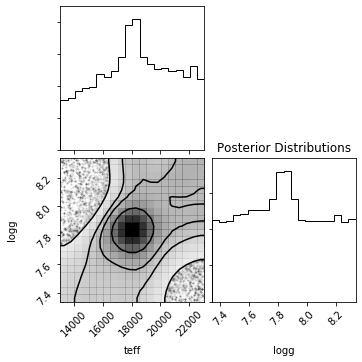

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.31845074
    reduced chi-square = 0.00108247
    Akaike info crit   = -8328.78150
    Bayesian info crit = -8318.56829
[[Variables]]
    teff:   18223.9048 +/- 3033.05095 (16.64%) (init = 18052.64)
    logg:   7.83546535 +/- 0.32582629 (4.16%) (init = 7.8383)
    trans: -0.7268272 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.181


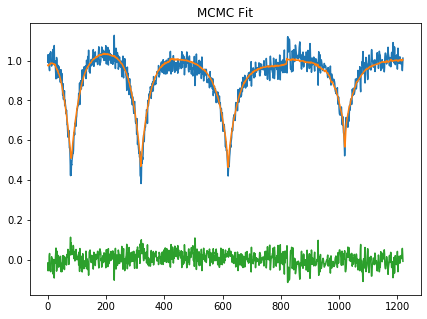




























 86%|████████▌ | 48/56 [28:08<04:44, 35.53s/it]

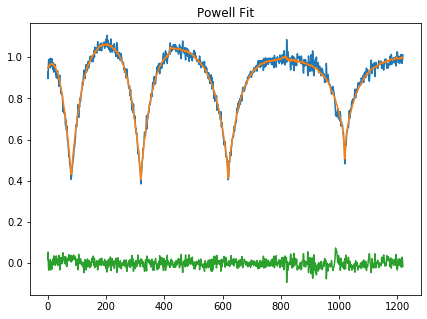

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 467
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.42494895
    reduced chi-square = 3.4918e-04
    Akaike info crit   = -9708.11870
    Bayesian info crit = -9692.79888
[[Variables]]
    teff:   13000.0232 +/- 3.83342869 (0.03%) (init = 20000)
    logg:   7.83350716 +/- 0.00423921 (0.05%) (init = 8)
    trans: -0.72367979 +/- 0.08181798 (11.31%) (init = 0)

 Starting Bayesian Sampling................
...Done.


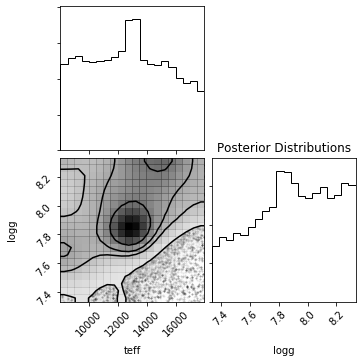

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.46815180
    reduced chi-square = 3.8436e-04
    Akaike info crit   = -9591.99396
    Bayesian info crit = -9581.78074
[[Variables]]
    teff:   12831.0289 +/- 3171.00156 (24.71%) (init = 13000.02)
    logg:   7.89940692 +/- 0.31427977 (3.98%) (init = 7.833507)
    trans: -0.7236798 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.138


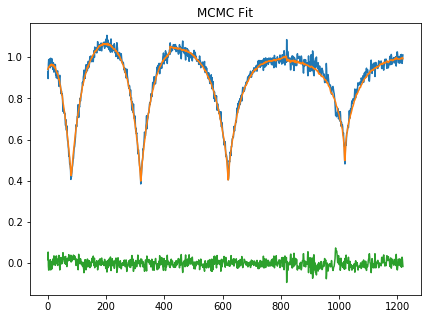




























 88%|████████▊ | 49/56 [28:44<04:10, 35.72s/it]

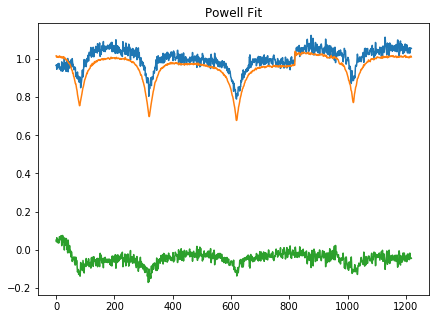

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 141
    # data points      = 1220
    # variables        = 3
    chi-square         = 3.93793615
    reduced chi-square = 0.00323577
    Akaike info crit   = -6991.85823
    Bayesian info crit = -6976.53841
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   76595.6749 (init = 20000)
    logg:   7.17129708 (init = 8)
    trans: -0.52375479 (init = 0)

 Starting Bayesian Sampling................
...Done.


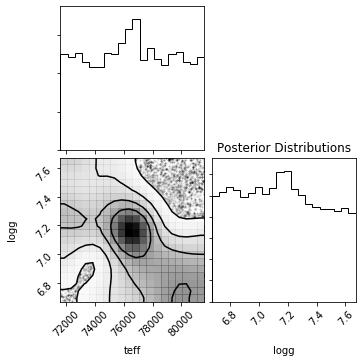

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 3.93798505
    reduced chi-square = 0.00323316
    Akaike info crit   = -6993.84308
    Bayesian info crit = -6983.62987
[[Variables]]
    teff:   76594.7188 +/- 3342.71373 (4.36%) (init = 76595.67)
    logg:   7.15400435 +/- 0.33190002 (4.64%) (init = 7.171297)
    trans: -0.5237548 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) = -0.106


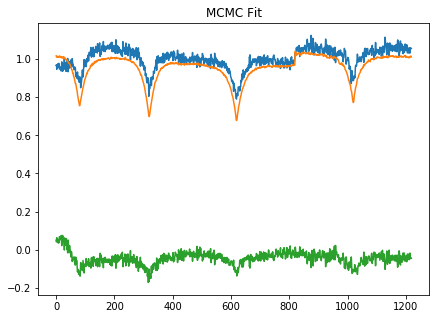




























 89%|████████▉ | 50/56 [29:19<03:32, 35.36s/it]

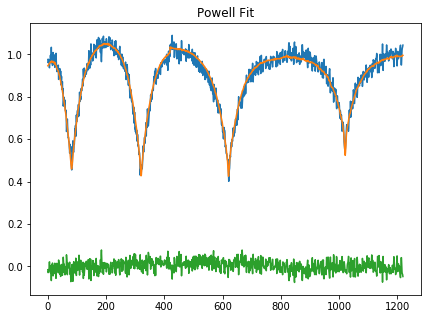

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 295
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.82325304
    reduced chi-square = 6.7646e-04
    Akaike info crit   = -8901.33932
    Bayesian info crit = -8886.01950
[[Variables]]
    teff:   17071.9060 +/- 181.622062 (1.06%) (init = 20000)
    logg:   8.15814195 +/- 0.08875757 (1.09%) (init = 8)
    trans:  0.37973745 +/- 0.12553961 (33.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.872

 Starting Bayesian Sampling................
...Done.


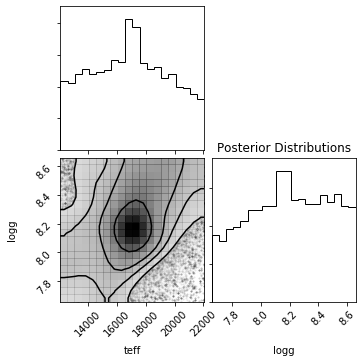

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.82473198
    reduced chi-square = 6.7712e-04
    Akaike info crit   = -8901.14961
    Bayesian info crit = -8890.93640
[[Variables]]
    teff:   16998.9338 +/- 3058.03939 (17.99%) (init = 17071.91)
    logg:   8.18701728 +/- 0.31476453 (3.84%) (init = 8.158142)
    trans:  0.3797375 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.148


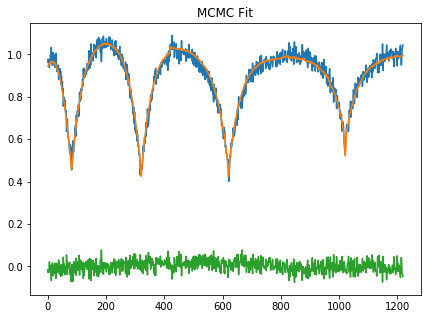




























 91%|█████████ | 51/56 [29:54<02:57, 35.47s/it]

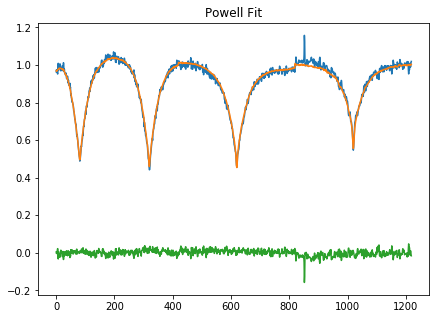

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 272
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.31269131
    reduced chi-square = 2.5694e-04
    Akaike info crit   = -10082.3568
    Bayesian info crit = -10067.0370
[[Variables]]
    teff:   17783.3427 +/- 168.922194 (0.95%) (init = 20000)
    logg:   7.88260356 +/- 0.01196826 (0.15%) (init = 8)
    trans: -0.15117192 +/- 0.08086264 (53.49%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.950

 Starting Bayesian Sampling................
...Done.


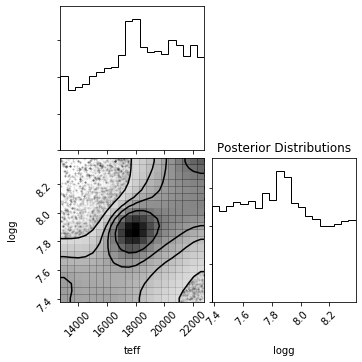

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.34676190
    reduced chi-square = 2.8470e-04
    Akaike info crit   = -9958.18210
    Bayesian info crit = -9947.96888
[[Variables]]
    teff:   18205.2653 +/- 3155.02452 (17.33%) (init = 17783.34)
    logg:   7.86009783 +/- 0.32595040 (4.15%) (init = 7.882604)
    trans: -0.1511719 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.229


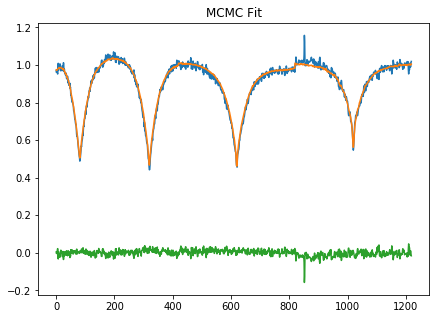




























 93%|█████████▎| 52/56 [30:30<02:21, 35.38s/it]

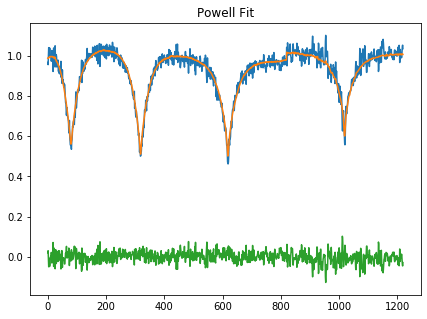

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 84
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.88302975
    reduced chi-square = 7.2558e-04
    Akaike info crit   = -8815.82309
    Bayesian info crit = -8800.50327
[[Variables]]
    teff:   24148.2223 +/- 858.027941 (3.55%) (init = 20000)
    logg:   7.98716127 +/- 0.10775304 (1.35%) (init = 8)
    trans: -1.59700358 +/- 0.13482656 (8.44%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.980

 Starting Bayesian Sampling................
...Done.


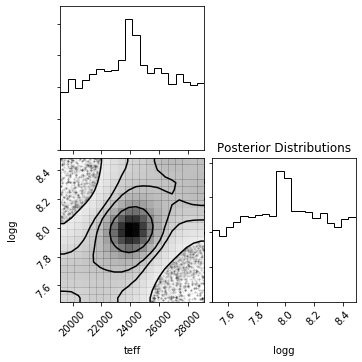

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.88315835
    reduced chi-square = 7.2509e-04
    Akaike info crit   = -8817.64542
    Bayesian info crit = -8807.43221
[[Variables]]
    teff:   24148.7815 +/- 3117.97592 (12.91%) (init = 24148.22)
    logg:   7.98905072 +/- 0.31835329 (3.98%) (init = 7.987161)
    trans: -1.597004 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.176


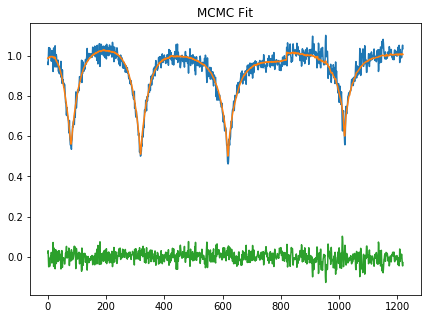




























 95%|█████████▍| 53/56 [31:05<01:45, 35.27s/it]

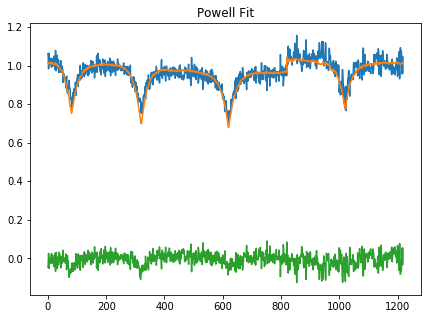

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 150
    # data points      = 1220
    # variables        = 3
    chi-square         = 1.39644365
    reduced chi-square = 0.00114745
    Akaike info crit   = -8256.66641
    Bayesian info crit = -8241.34659
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   76467.4769 (init = 20000)
    logg:   7.17984673 (init = 8)
    trans:  0.11801356 (init = 0)

 Starting Bayesian Sampling................
...Done.


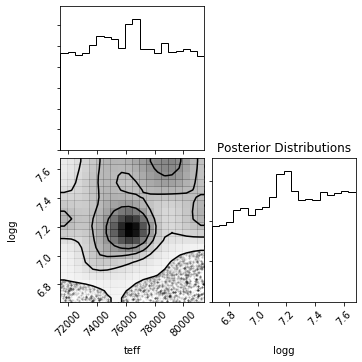

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 1.39650823
    reduced chi-square = 0.00114656
    Akaike info crit   = -8258.60999
    Bayesian info crit = -8248.39677
[[Variables]]
    teff:   76443.5342 +/- 3308.71650 (4.33%) (init = 76467.48)
    logg:   7.20858642 +/- 0.32822877 (4.55%) (init = 7.179847)
    trans:  0.1180136 (fixed)


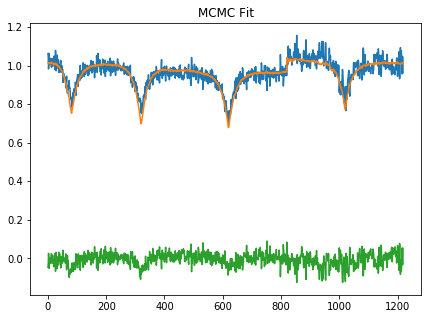




























 96%|█████████▋| 54/56 [31:39<01:09, 35.00s/it]

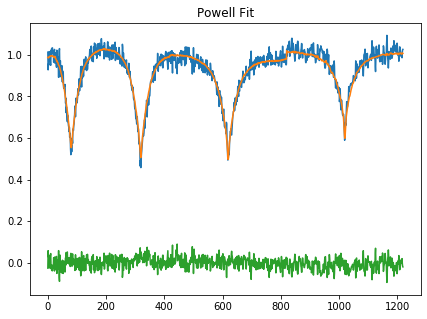

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 396
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.87290962
    reduced chi-square = 7.1726e-04
    Akaike info crit   = -8829.88586
    Bayesian info crit = -8814.56604
[[Variables]]
    teff:   19267.5275 +/- 2479.58144 (12.87%) (init = 20000)
    logg:   7.26705516 +/- 0.46432228 (6.39%) (init = 8)
    trans: -0.71893730 +/- 0.12985217 (18.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.998

 Starting Bayesian Sampling................
...Done.


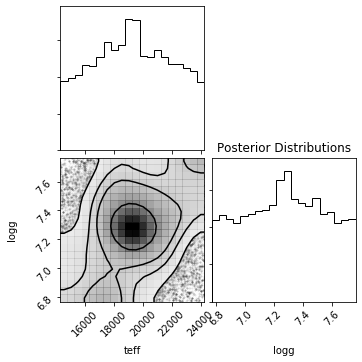

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.87305911
    reduced chi-square = 7.1680e-04
    Akaike info crit   = -8831.67695
    Bayesian info crit = -8821.46374
[[Variables]]
    teff:   19266.0522 +/- 3090.41902 (16.04%) (init = 19267.53)
    logg:   7.27111610 +/- 0.32052899 (4.41%) (init = 7.267055)
    trans: -0.7189373 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.112


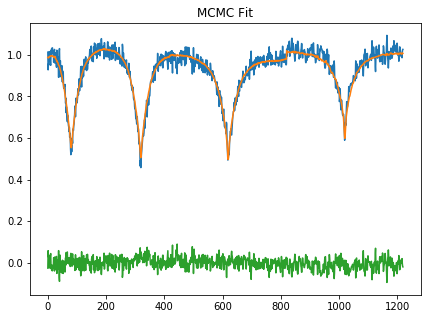




























 98%|█████████▊| 55/56 [32:15<00:35, 35.20s/it]

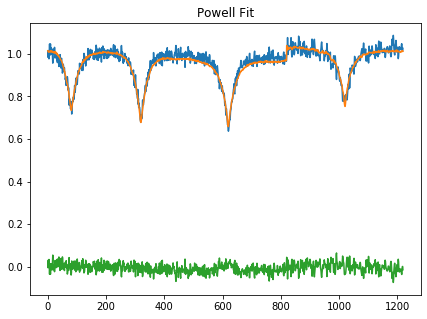

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 138
    # data points      = 1220
    # variables        = 3
    chi-square         = 0.58132554
    reduced chi-square = 4.7767e-04
    Akaike info crit   = -9325.84161
    Bayesian info crit = -9310.52179
##  Warning: uncertainties could not be estimated:
[[Variables]]
    teff:   37171.8280 +/-        nan (nan%) (init = 20000)
    logg:   8.00206037 +/-        nan (nan%) (init = 8)
    trans: -0.34959881 +/- 0.14452788 (41.34%) (init = 0)

 Starting Bayesian Sampling................
...Done.


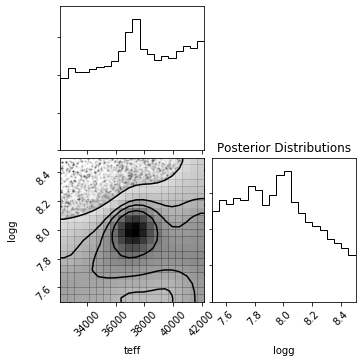

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25000
    # data points      = 1220
    # variables        = 2
    chi-square         = 0.58646570
    reduced chi-square = 4.8150e-04
    Akaike info crit   = -9317.10163
    Bayesian info crit = -9306.88841
[[Variables]]
    teff:   37396.8245 +/- 3333.78502 (8.91%) (init = 37171.83)
    logg:   7.94312641 +/- 0.30198577 (3.80%) (init = 8.00206)
    trans: -0.3495988 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(teff, logg) =  0.100


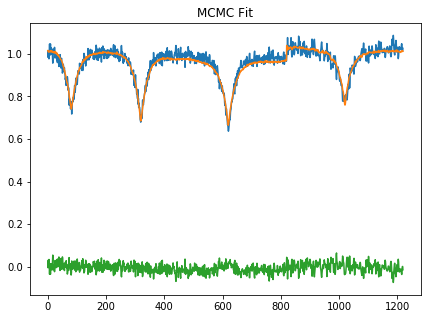




























100%|██████████| 56/56 [32:50<00:00, 35.26s/it]

In [387]:
fitoutput = np.zeros((len(y_test),5))
bayesoutput = np.zeros((len(y_test),5))
for i in tqdm(range(len(y_test))):
    spec = y_test[i][lines]
    fitoutput[i,0] = int(specnames[i][:-12])
    bayesoutput[i,0] = int(specnames[i][:-12])
    #params['teff'].set(value=sc.inverse_transform(X_test)[i,0],vary=True)
    result = fitter.fit(spec*modelscaling,params,wl=lamgrid[lines],method="powell",nan_policy='omit',calc_covar=True,
                       fit_kws={'reduce_fcn':chisquare})
    
    fitoutput[i,1] = result.params['teff'].value
    fitoutput[i,2] = result.params['teff'].stderr
    fitoutput[i,3] = result.params['logg'].value
    fitoutput[i,4] = result.params['logg'].stderr
    
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(spectrum_sampler(None,result.params['teff'],result.params['logg'],result.params['trans']))
    plt.plot(result.residual)
    plt.title('Powell Fit')
    plt.show()
    print(lmfit.fit_report(result))
    bayesparams['teff'].set(min=result.params['teff'].value-5000,max=result.params['teff'].value+5000,value = result.params['teff'].value)
    bayesparams['logg'].set(min=result.params['logg'].value-0.5,max=result.params['logg'].value+0.5, value = result.params['logg'])
    print('\n Starting Bayesian Sampling................')
    bayesparams['trans'].set(value = result.params['trans'].value,vary=False)
    bayesresult = fitter.fit(spec*modelscaling,bayesparams,wl=lamgrid[lines],method="emcee",nan_policy='omit',\
                             calc_covar=True, fit_kws={'nwalkers':50,'steps':500})
    print('...Done.')
    f = corner.corner(bayesresult.flatchain[['teff','logg']],smooth=2)
    plt.title('Posterior Distributions')
    plt.show()
    print(lmfit.fit_report(bayesresult))
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(spectrum_sampler(None,bayesresult.params['teff'],bayesresult.params['logg'],bayesresult.params['trans']))
    plt.plot(result.residual)
    plt.title('MCMC Fit')
    plt.show()
    bayesoutput[i,1] = bayesresult.params['teff'].value
    bayesoutput[i,2] = bayesresult.params['teff'].stderr
    bayesoutput[i,3] = bayesresult.params['logg'].value
    bayesoutput[i,4] = bayesresult.params['logg'].stderr

In [388]:
true_labels = sc.inverse_transform(X_test)

Text(0.5, 0.1, 'rms: 11601 K, bias: -3290 K')

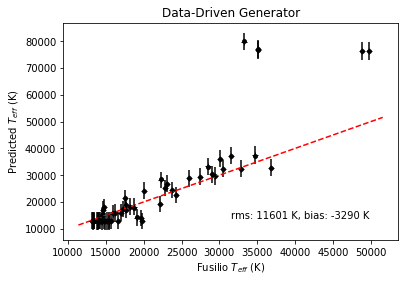

In [412]:
true = true_labels[:,0]
pred = fitoutput[:,1]
bpred = bayesoutput[:,1]
f=plt.scatter(true,pred,s=15,color='k')
f2=plt.errorbar(true,bpred,yerr=bayesoutput[:,2],linestyle='None',color='k',marker='+')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Data-Driven Generator')

rms = np.sqrt((np.sum((true-bpred)**2) / len(true)))
bias = np.mean(true-bpred)
plt.text(0.5,0.1,'rms: %i K, bias: %i K'%(rms,bias),transform=f.axes.transAxes)

Text(0.5, 0.1, 'rms: 0.63 dex, bias: -0.12 dex')

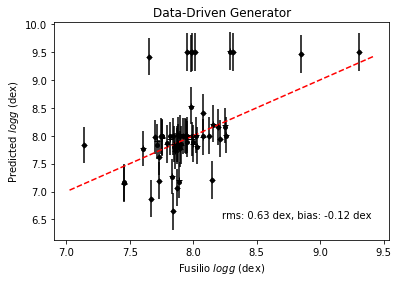

In [411]:
true = true_labels[:,1]
pred = fitoutput[:,3]
bpred = bayesoutput[:,3]
f=plt.scatter(true,pred,s=15,color='k')
f2=plt.errorbar(true,bpred,yerr=bayesoutput[:,4],linestyle='None',color='k',marker='+')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $logg$ (dex)')
plt.ylabel('Predicted $logg$ (dex)')
plt.title('Data-Driven Generator')
rms = np.sqrt((np.sum((true-bpred)**2) / len(true)))
bias = np.mean(true-bpred)
plt.text(0.5,0.1,'rms: %.2f dex, bias: %.2f dex'%(rms,bias),transform=f.axes.transAxes)

In [381]:
from importlib import reload
reload(fitfunctions)

<module 'fitfunctions' from '/home-net/home-4/vchandr8@jhu.edu/wd/fitfunctions.py'>

In [382]:
from multiprocessing import Pool
from functools import partial

In [383]:
pool_func = partial(fitfunctions.MCMC_fit,model=fitter,params=bayesparams,grid=lamgrid[lines],ncores=1,lines=lines)

In [385]:
pool_func(y_test[0])

emcee: Exception while calling your likelihood function:
  params: [1.50101568e+04 7.84714301e+00]
  args: (<bound method Model._residual of <lmfit.Model: Model(spectrum_sampler)>>, Parameters([('teff', <Parameter 'teff', 15010.15678085919, bounds=[10011.585858467432:20011.58585846743]>), ('logg', <Parameter 'logg', 7.847143012527541, bounds=[7.3459927127222695:8.34599271272227]>), ('trans', <Parameter 'trans', value=0.39200378752727083 (fixed), bounds=[-inf:inf]>)]), ['teff', 'logg'], array([[1.00115859e+04, 2.00115859e+04],
       [7.34599271e+00, 8.34599271e+00]]))
  kwargs: {'is_weighted': True, 'float_behavior': 'posterior', 'userargs': (array([1.0117425 , 1.01281879, 0.97299677, ..., 1.05882668, 1.06406932,
       0.99423869]), None), 'userkws': {'wl': array([4022, 4023, 4024, ..., 6762, 6763, 6764])}, 'nan_policy': 'omit'}
  exception:


Traceback (most recent call last):
  File "/home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/lmfit/minimizer.py", line 2038, in _lnpost
    out = userfcn(params, *userargs, **userkwargs)
  File "/home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/lmfit/model.py", line 753, in _residual
    diff = self.eval(params, **kwargs) - data
  File "/home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/lmfit/model.py", line 833, in eval
    return self.func(**self.make_funcargs(params, kwargs))
  File "<ipython-input-246-156d4836032d>", line 6, in spectrum_sampler
    synth = (interpolation.shift(model.predict(label)[0],trans,cval=np.nan)*modelscaling)
  File "/home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/scipy/ndimage/interpolation.py", line 538, in shift
    _nd_image.zoom_shift(filtered, Non

KeyboardInterrupt: 

In [386]:
if __name__ == '__main__':
    with Pool(1) as pool:
        res = pool.imap(pool_func,y_test[0:1])
        for i in res:
            print(i)

KeyboardInterrupt: 

KeyboardInterrupt: 